# Biophysical and reduced neuronal models

## Generic code architecture for model construction

In [7]:
#Modl params

#Run controls

#DAQ vector instantiation

#Initialization

#Helper fxns (eqns)

#Integrator

#Package DAQ vector(s) into intuitive data structure

#I.O

## Hodgkin-Huxley neuron model

### Charge conservation equation

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + I_{0}$$

### Current equations (where i $\in$ {Na, K, pas} and j, k, z $\geq$ 0)

$$I_{i} = \bar{g}_{i}m^{j}h^{k}n^{z}(V - E_{i})$$

### Gating dynamic equations (where p $\in$ {m, h, b})

$$\frac{dp}{dt} = \alpha_{p}(V_m)(1 - p) - \beta_{p}(V_{m})p$$

### Rate constant equations

#### m

$$\alpha_{m} = \frac{0.01(25 - V_{m})}{e^{\frac{25 - V_{m}}{10}} - 1}$$

$$\beta_{m} = 4e^{-\frac{V_{m}}{18}}$$

#### h

$$\alpha_{h} = 0.07e^{-\frac{V_{m}}{20}}$$

$$\beta_{h} = \frac{1}{e^{\frac{30 - V_{m}}{10}} - 1}$$

#### n

$$\alpha_{n} = \frac{0.01(10 - V_{m})}{e^{\frac{10 - V_{m}}{10}} - 1}$$

$$\beta_{n} = 0.125e^{-\frac{V_{m}}{80}}$$

#### $\infty$ (steady-state) equations (where p $\in$ {m, h, n})

$$p_{\infty} = \frac{\alpha_{p}}{\alpha_{p} + \beta_{p}} $$


In [2]:
###Sys block
from warnings import simplefilter
simplefilter(action = 'ignore')
from random import seed
seed(120622)

###Lib block
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sbn
from random import gauss, uniform
from sklearn.metrics import mean_squared_error as mse
from IPython.display import HTML, Image
import ray as rClust
from tqdm import tqdm
from scipy.signal import find_peaks
import unidip.dip as dip
from glob import glob

In [3]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
i_, c_m = 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiations
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, i_, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + i_) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              i_, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-3.220631
1,960.025,-3.167730
2,960.050,-3.114805
3,960.075,-3.061856
4,960.100,-3.008888


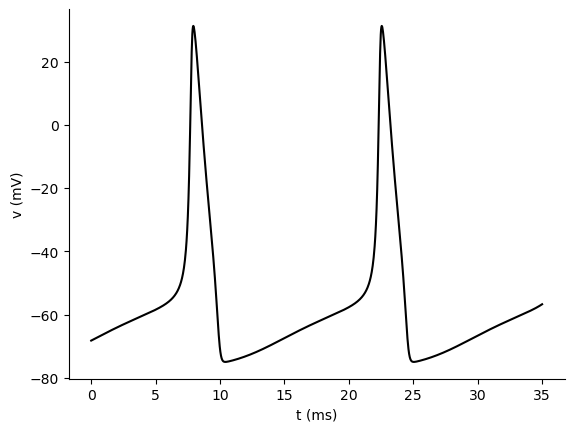

In [4]:
#Visualization
plt.figure()
plt.plot(data['t'] - min(data['t']), 
         data['v'] - 65,
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Hodgkin-Huxley model compared to biological spiker

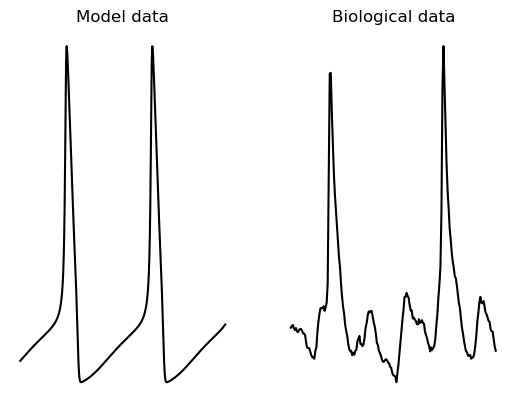

In [5]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hodgkin-Huxley model with noise compared to biological spiker

### Charge conservation equation with additive noise

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + w\xi + I_{0}$$


In [6]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
w, i_, c_m = 25, 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiations
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, w, i_, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + (w * gauss(mu = 0, sigma = 1)) + i_) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              w, i_, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-8.686479
1,960.025,-7.601745
2,960.050,-7.555722
3,960.075,-7.411587
4,960.100,-8.228261


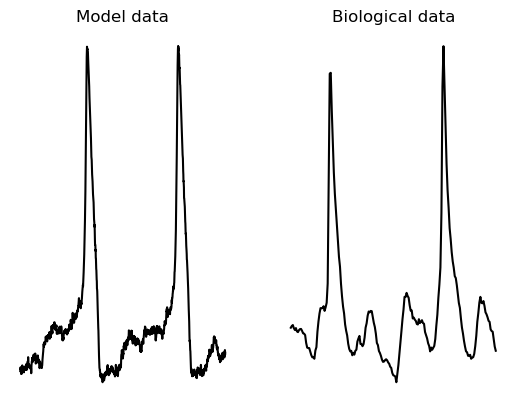

In [7]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose neuron model

### System of differential equations

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + i$$

$$\frac{dy}{dt} = c - dx^{2} - y$$

$$\frac{dz}{dt} = r(s(x - x_{1}) - z)$$

In [8]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * (x ** 3) + b * (x ** 2) - z + i_
    dydt = c - d * (x ** 2) - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.532801
1,1000.01,-1.532784
2,1000.02,-1.532768
3,1000.03,-1.532751
4,1000.04,-1.532735


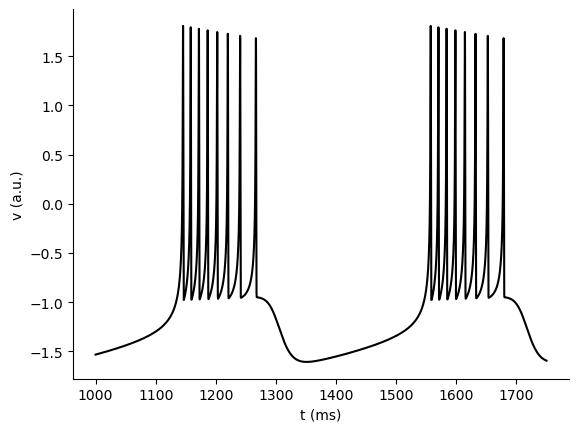

In [9]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['x'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (a.u.)')
plt.show()

## Hindmarsh-Rose model compared to biological burster

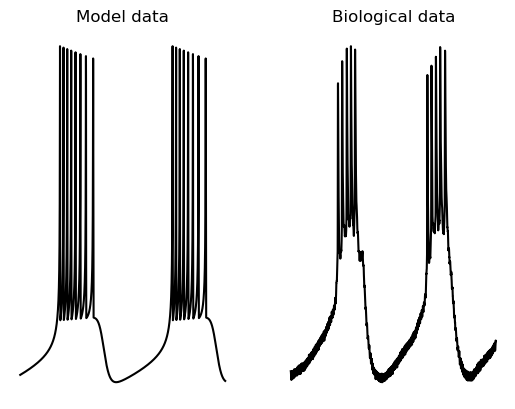

In [10]:
#Data dump
biolData = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose model with noise compared to biological burster

### Voltage-representing, state-variable equation with additive noise

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + w\xi + i$$

In [11]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2
w = 1

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * x ** 3 + b * x ** 2 - z + (w * gauss(mu = 0, sigma = 1)) + i_
    dydt = c - d * x ** 2 - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.472408
1,1000.01,-1.482756
2,1000.02,-1.483776
3,1000.03,-1.480185
4,1000.04,-1.478846


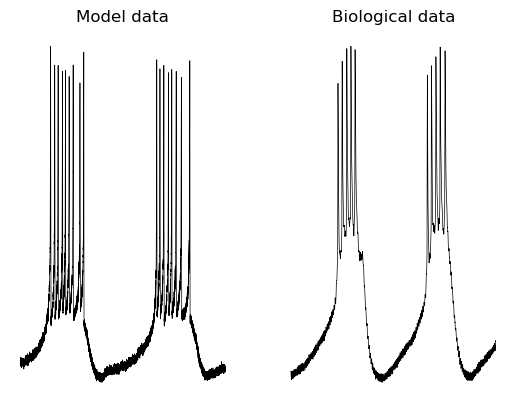

In [12]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         linewidth = 0.5,
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         linewidth = 0.5,
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Draw visualization to jupyter
plt.show()

## Izhikevich neuron model

### System of differential equations

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + i$$

$$\frac{du}{dt} = a(bv - u)$$

<br><br>

<p style = "text-align: center;">if $v = 30 \: mV$, then:</p> 

$$v \leftarrow c$$
$$u \leftarrow u + d$$

## ...as spiker

In [13]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
i_ = 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-70.935316
1,900.01,-70.932249
2,900.02,-70.929181
3,900.03,-70.926114
4,900.04,-70.923046


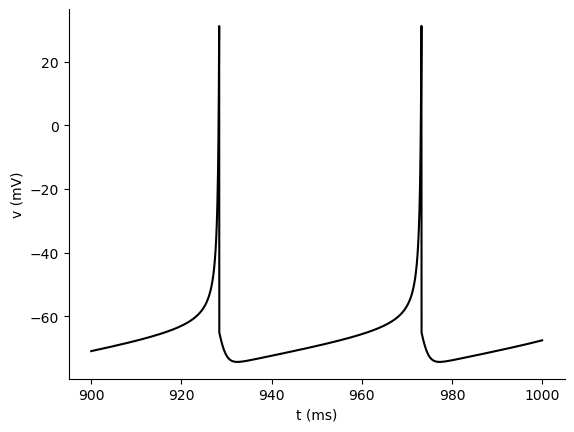

In [14]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## ...as burster

In [15]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
i_ = 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-69.019385
1,900.01,-69.014446
2,900.02,-69.009506
3,900.03,-69.004563
4,900.04,-68.999619


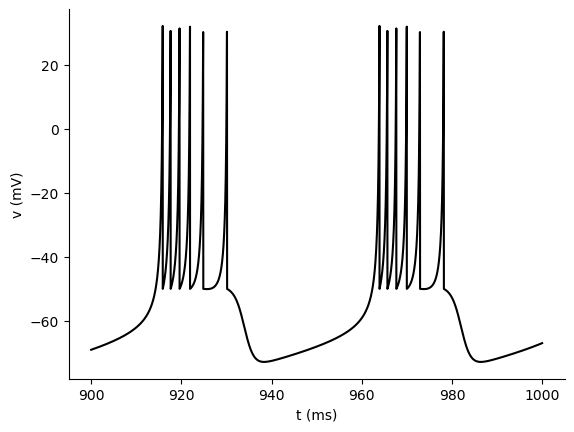

In [16]:
#Visualization
plt.figure()
plt.plot(data_['t'], 
         data_['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Izhikevich model compared to biological neurons

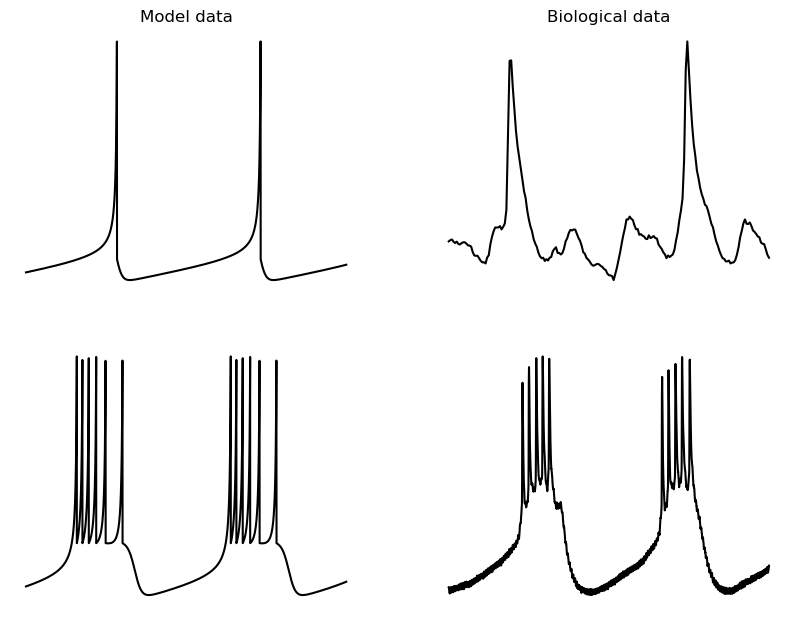

In [17]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')
biolData_ = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure(figsize = (10, 7.5))

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()

## Izhikevich model with noise compared to biological neurons

### Voltage-representing, state-variable equation with additive noise

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + w\xi + i$$

## ...as spiker

In [18]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
w, i_ = 10, 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-69.244225
1,900.01,-69.222449
2,900.02,-69.261061
3,900.03,-69.312373
4,900.04,-69.442575


## ...as burster

In [19]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
w, i_ = 10, 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i,_ in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                      'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-62.993644
1,900.01,-62.786875
2,900.02,-62.499059
3,900.03,-62.436780
4,900.04,-62.565752


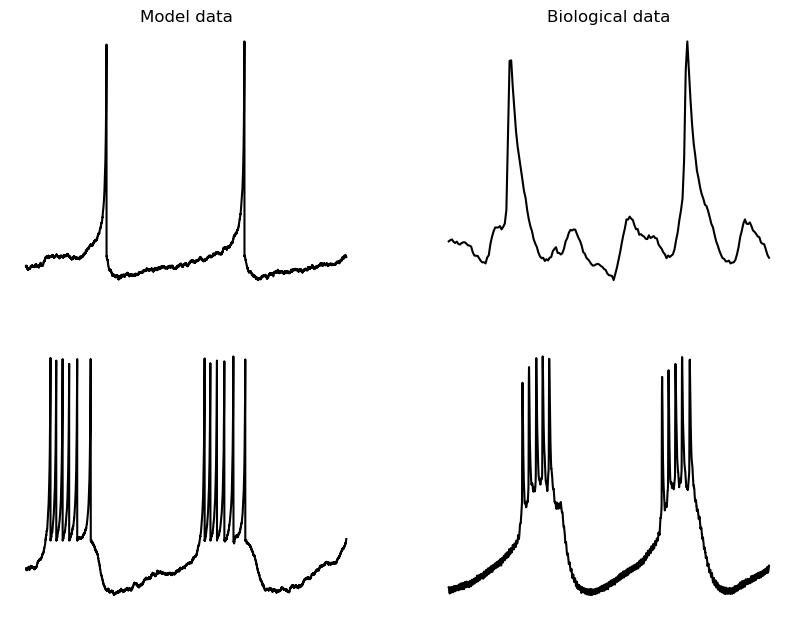

In [20]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (10, 7.5))

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()

# Parameter search and optimization methodologies

## Toy univariate linear regression model

$$y = mx + b$$

In [21]:
###Main block
#Modl params
m, b = 100, 10

#IV/feature/predictor/EV vector
x = np.arange(1, (10 + 1))

#Helper fxn (eqn)
def fx():
    return(m * x + b)

#Compute modl output
y = fx()
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'x': x,
                     'y': y})

#I.O
data.head()

,x,y
0,1,110
1,2,210
2,3,310
3,4,410
4,5,510


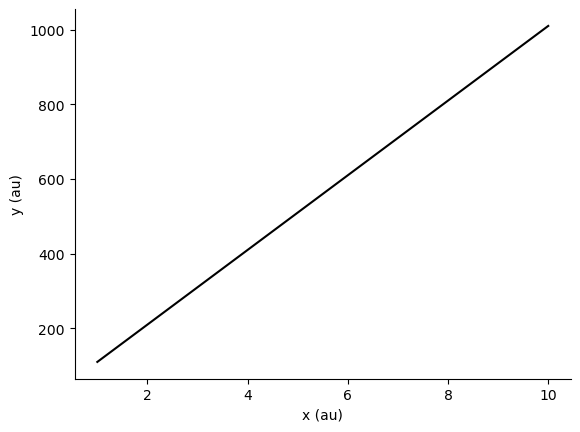

In [22]:
#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.show()

## Parameter search (hand-tuning; brute-force; random parameter)

### Functionalize toy model

In [23]:
###Fxn block
def toyModl(m, b = 10):
    '''
    
    Fxnalized univariate linear regression modl object
    
    - Modl params are now fxn args
        * m is parg/kwarg
        * b is darg
    
    '''
    
    #IV/feature/predictor/EV vector
    x = np.arange(1, (10 + 1))
    
    #Helper fxn (eqn)
    def fx():
        return(m * x + b)
    
    #Compute modl output
    y = fx()
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'x': x,
                         'y': y})
    
    #I.O
    return(data)

###Main block
#Compute modl results
toyModl(m = 100).head()

,x,y
0,1,110
1,2,210
2,3,310
3,4,410
4,5,510


### Hand-tune toy model

$$m \in [0, 100]$$

m = 50


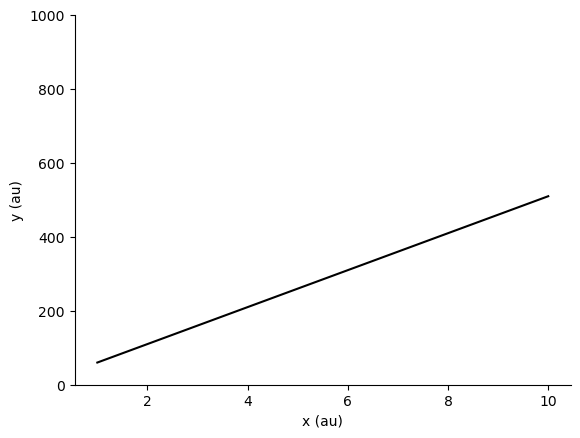

In [24]:
###Main block
#Compute modl results
data = toyModl(m = int(input('m =')))

#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)
plt.show()

### Subject toy model to brute-force, sparse-grid search

In [25]:
###Main block
##Create param iterable
#Sparse 1D grid comprising feature space
m = np.arange(0, 100, 10)

#DAQ list-column instantiation
modls = []

#Compute modl outputs across grid
for i,_ in enumerate(m):
    #Conditionally capture x and y for first iteration
    if i == 0:
        modls.append(toyModl(m = m[i]))

    #Conditionally capture y for remainder of iterations
    else:
        modls.append(toyModl(m = m[i])['y'] \
             .rename(f'y{i}'))
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,x,y,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,1,10,20,30,40,50,60,70,80,90,100
1,2,10,30,50,70,90,110,130,150,170,190
2,3,10,40,70,100,130,160,190,220,250,280
3,4,10,50,90,130,170,210,250,290,330,370
4,5,10,60,110,160,210,260,310,360,410,460


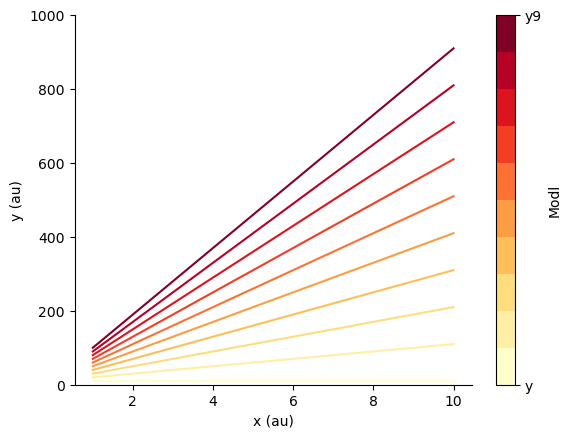

In [26]:
##Visualization
#Creation of graphics device
plt.figure()

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.iloc[:, 1:]))
clrs = cmap(range(len(data.iloc[:, 1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Alter graphics device attributes
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

#Build legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Render visualization to jupyter
plt.show()

### Subject toy model to random parameter search

In [27]:
###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ list-column instantiation
modls = []

#Compute modl outputs subject to Monte-Carlo param (m) selection
while i <= n:
    #Conditionally capture x and y for first iteration
    if i == 0:
        modls.append(toyModl(m = uniform(0, 100 + 1)))

    #Conditionally capture y for remainder of iterations
    else:
        modls.append(toyModl(m = uniform(0, 100 + 1))['y'] \
             .rename(f'y{i}'))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,x,y,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,1,62.558415,62.259131,39.798298,85.777635,106.686368,16.722492,18.762590,21.779533,89.596867,95.836452
1,2,115.116830,114.518263,69.596596,161.555270,203.372737,23.444984,27.525181,33.559065,169.193733,181.672905
2,3,167.675245,166.777394,99.394894,237.332906,300.059105,30.167475,36.287771,45.338598,248.790600,267.509357
3,4,220.233660,219.036526,129.193192,313.110541,396.745474,36.889967,45.050361,57.118131,328.387467,353.345809
4,5,272.792075,271.295657,158.991490,388.888176,493.431842,43.612459,53.812951,68.897664,407.984334,439.182262


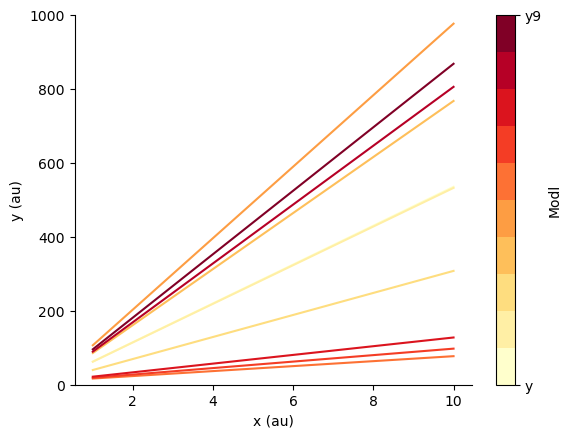

In [28]:
##Visualization
#Creation of graphics device
plt.figure()

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.iloc[:, 1:]))
clrs = cmap(range(len(data.iloc[:, 1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Alter graphics device attributes
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

#Build legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Render visualization to jupyter
plt.show()

## Optimization methodologies (random parameter search; gradient descent)

### Optimization (i.e., target) data

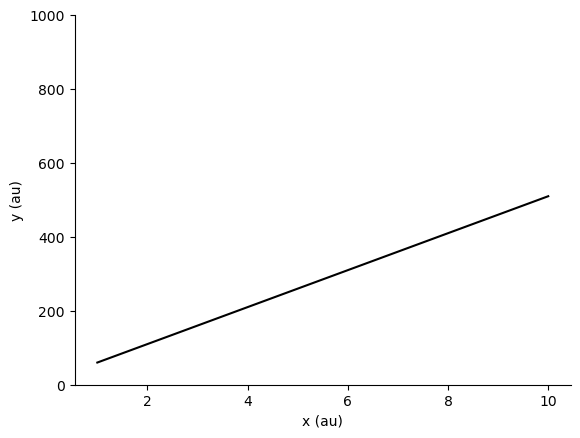

In [29]:
###Main block
##Compute modl results
#Use complex (i.e., multi-) object assignment
data = optoData \
     = toyModl(m = 50)

#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)
plt.show()

### Optimize toy model to target data using random parameter search

In [30]:
###Fxn block
def sideBySide(*dfs):
    '''

    Jupyter render fxn, placing variable number of dfs side-by-side
    
    '''
    
    ##Construct div object with column-wise 'display:flex' div style
    html = '<div style = "display:flex">'
    
    #Iteratively concat dfs column-wise
    for df in dfs:
        #Appending df html to root div object
        html += '<div style = "margin-right: 2em">' \
             +  df.to_html() \
             +  '</div>'

    #Close root div
    html += '</div>'

    #Render root div to jupyter
    display(HTML(html))

###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ tensor instantiations
modls = []
error = []

#Compute modl outputs subject to Monte-Carlo param (m) selection
while i <= n:
    if i == 0:
        #Conditionally capture x and y for first iteration
        modls.append(toyModl(m = uniform(0, 100 + 1)))

        #Capture MSE error signal between target data and modl output for first iteration
        error.append(mse(optoData['y'], modls[i]['y']))

    else:
        #Conditionally capture y for remainder of iterations
        modls.append(toyModl(m = uniform(0, 100 + 1))['y'] \
             .rename(f'y{i}'))

        #Capture MSE error signal between target data and modl output for remainder of iterations
        error.append(mse(optoData['y'], modls[i]))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)
data_ = pd.DataFrame({'modl': data.columns.values[1:],
                      'err': error})

#I.O
sideBySide(data.head(), data_.head())

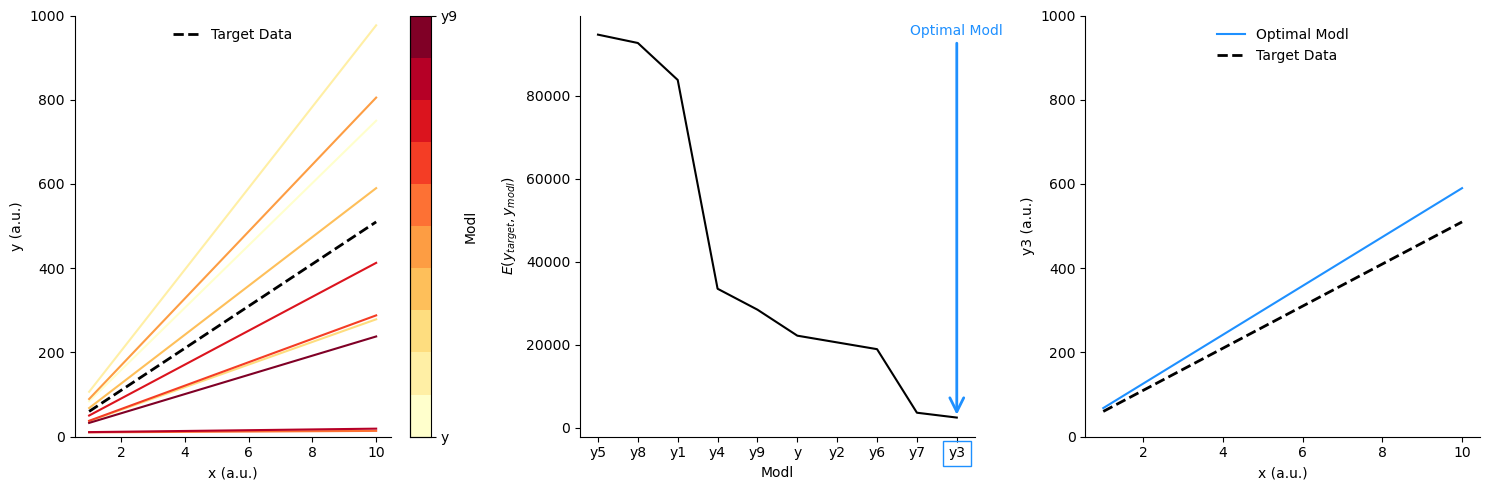

In [31]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 5))

#Instantiate first panel (modl data)
plt.subplot(131)

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.columns[1:]))
clrs = cmap(range(len(data.columns[1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         linestyle = 'dashed',
         linewidth = 2,
         color = 'black',
         label = 'Target Data')

#Alter subplot 131 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

##Build legend
#Standard legend with mappable 'label'
plt.legend(frameon = False,
           loc = 'upper center')

#Color-encoded legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Instantiate second panel (biological data)
plt.subplot(132)

#Wrangle for visualization
temp = data_.sort_values(by = 'err', ascending = False) \
            .reset_index()

#Construct figure
plt.plot(temp['modl'], 
         temp['err'],
         color = 'black')

#Identify min in error landscape (i.e., optimal modl)
plt.annotate(text = 'Optimal Modl', 
             xy = (temp[(temp['err'] == min(temp['err']))]['modl'].index[0], 
                   temp['err'].min()), 
             xytext = (temp[(temp['err'] == min(temp['err']))]['modl'].index[0], 
                       temp['err'].max()),
             horizontalalignment = 'center',
             arrowprops = dict(arrowstyle = '->, ' \
                                          + 'head_width = 0.5, ' \
                                          + 'head_length = 1',
                               linewidth = 2,
                               color = 'dodgerblue'),
             color = 'dodgerblue')

#Highlight optimal model
plt.gca() \
   .xaxis \
   .get_ticklabels()[temp[(temp['err'] == min(temp['err']))]['modl'] \
   .index[0]] \
   .set_bbox(dict(facecolor = 'none', 
                  edgecolor = 'dodgerblue'))

#Alter subplot 132 attributes
sbn.despine()
plt.xlabel('Modl')
plt.ylabel('$E(y_{target}, y_{modl})$')

#Instantiate third panel (optimized modl data)
plt.subplot(133)

#Construct figure
plt.plot(data['x'], 
         data[data_[(data_['err'] == min(data_['err']))]['modl']],
         color = 'dodgerblue',
         label = 'Optimal Modl')

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         linestyle = 'dashed',
         linewidth = 2,
         color = 'black',
         label = 'Target Data')

#Alter subplot 133 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel(f'y{data_[(data_["err"] == min(data_["err"]))]["modl"].index[0]} (a.u.)')
plt.ylim(0, 1000)

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper center')

#Alter graphics device layout
plt.tight_layout()

#Render visualization to jupyter
plt.show()

### Optimize toy model to target data using gradient descent

#### Recapitulate toy model as simple neural network (i.e., a simple perceptron)

<p style = 'text-align:center;'><img src = './fts/simplePerceptron.jpg' alt = 'SimplePerceptron' width = '500' height = '1000'></p>

$$y = mx + b$$

<br><br>

<p style = 'text-align: center;'>where:</p> 

$$m \in [0, 100]$$

$$b = 10$$

#### Gradient descent algorithm

##### Master equation

$$m_{i + 1} = m_{i} - \mu\frac{\partial \xi}{\partial m}$$

##### Error/fitness/loss function for batch learning

$$\xi = \frac{1}{N} \sum_{1}^{N}{{\left\lvert Y_{target} - Y_{modl} \right\rvert}^{2}}$$

##### Solve $\frac{\partial \xi}{\partial m}$ using the chain rule

$$\frac{\partial \xi}{\partial m} = \frac{\partial \xi}{\partial Y_{modl}} \frac{\partial Y_{modl}}{\partial m}$$

<br><br>

$$\frac{\partial \xi}{\partial Y_{modl}} = \frac{\partial}{\partial Y_{modl}}(\frac{1}{N} \sum_{1}^{N}{{\left\lvert Y_{target} - Y_{modl} \right\rvert}^{2}})$$

$$ = \frac{1}{N} \sum_{1}^{N} {\frac{\partial}{\partial Y_{modl}}({Y_{target} - Y_{modl}})^{2}}$$

$$ = \frac{1}{N} \sum_{1}^{N}{2({Y_{modl} - Y_{target}})}$$

<br><br>

$$\frac{\partial Y_{modl}}{\partial m} = \frac{\partial}{\partial m}(mX + b)$$

$$ = X$$

<br><br>

$$\frac{\partial \xi}{\partial m} = \frac{\partial \xi}{\partial Y_{modl}} \frac{\partial Y_{modl}}{\partial m} = \frac{1}{N} \sum_{1}^{N}{2X({Y_{modl} - Y_{target}})}$$

#### Closed-form master equation

$$m_{i + 1} = m_{i} - \frac{\mu}{N} \sum_{1}^{N}{2X({Y_{modl} - Y_{target}})}$$

In [32]:
###Fxn block
def errorLandscape():
    '''

    Fxn creates error landscape for gradient descent
    
    '''
    ##Create param iterable
    #Sparse 1D grid comprising feature space
    m = np.arange(0 + 10, 100 - 9)
    
    #DAQ list-column instantiation
    errors = []
    
    #Compute modl outputs across grid
    for i,_ in enumerate(m):
        #Capture MSE error signal between target data and modl output
        errors.append(mse(optoData['y'], toyModl(m = m[i])['y']))
        
    #Transform to nd heterogenous df
    data = pd.DataFrame({'m': m, 
                         'err': errors})
    
    #I.O
    return(data)

###Main block
#Modl params
m = 15
u = 0.01

#Compute controls
i = 0
n = 10 - 1

##DAQ tensor instantiations
#Use complex (i.e., multi-) object assignment
modls = modl \
      = [toyModl(m)]
errors = [[m, mse(optoData['y'], toyModl(m)['y'])]]

#Helper fxns (eqns)
def weightedGradient(X, Y_modl, Y_target):
    return(u * np.mean(2 * X * (Y_modl - Y_target)))

#Implementation of gradient descent
while i <= n:
    if i == 0:
        #Compute gradient with learning rate
        dEdm = weightedGradient(modl[0]['x'], modl[0]['y'], optoData['y'])

    else:
        #Compute gradient with learning rate
        dEdm = weightedGradient(modl['x'], modl['y'], optoData['y'])

    #Update param
    m = m - dEdm

    #Compute modl output with updated param
    modl = toyModl(m)

    ##Capture data
    #Acquire modl data
    modls.append(modl['y'] \
         .rename(f'y{i}'))

    #Acquire optimization param and error data
    errors.append([m, mse(optoData['y'], modl['y'])])
    
    #Increase iterator
    i += 1

#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)
data_ = pd.DataFrame(errors, columns = ['m', 'err'])
data_.insert(loc = 0, 
             column = 'modl',
             value = data.columns.values[1:])


#I.O
sideBySide(data.head(), data_.head())

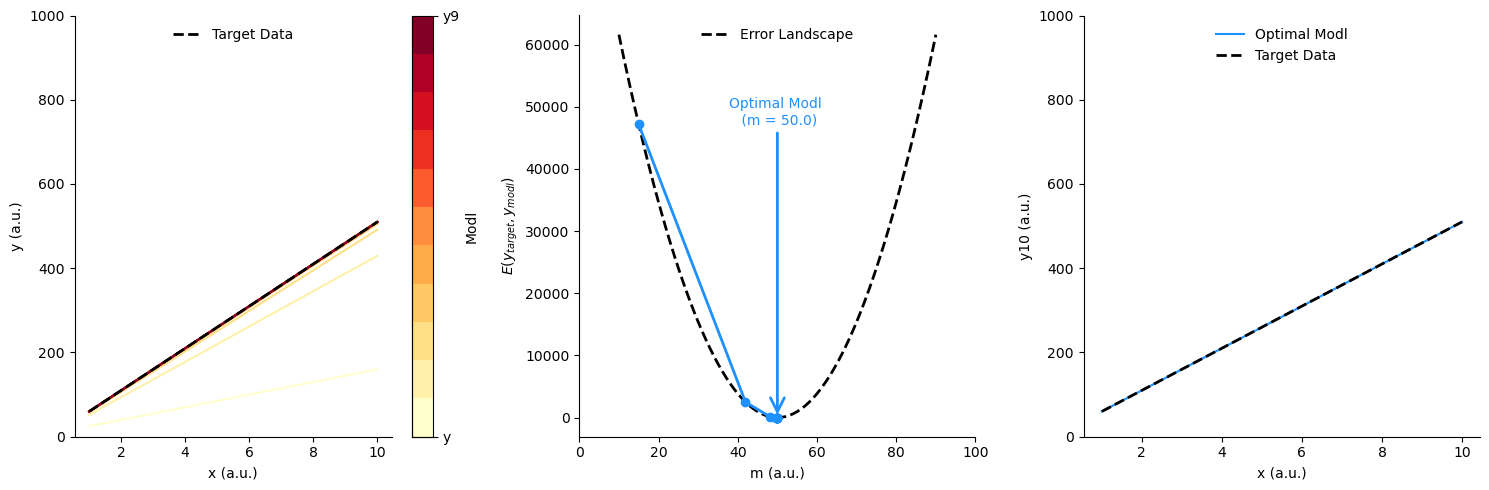

In [33]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 5))

#Instantiate first panel (modl data)
plt.subplot(131)

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.columns[1:]))
clrs = cmap(range(len(data.columns[1:])))

#Construct figure, iteratively plotting each modl's data
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = clrs[i])

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         linestyle = 'dashed',
         linewidth = 2,
         color = 'black',
         label = 'Target Data')

#Alter subplot 131 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')
plt.ylim(0, 1000)

#Create ScalarMappable object
sm = cm.ScalarMappable(cmap = cmap)

##Build legend
#Standard legend with mappable 'label'
plt.legend(frameon = False,
           loc = 'upper center')

#Color-encoded legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels([data.columns[1], data.columns[len(data.columns) - 1]])

#Instantiate second panel (biological data)
plt.subplot(132)

#Generate error landscape data
dataError = errorLandscape()

#Initialize figure with error well
plt.plot(dataError['m'],
         dataError['err'],
         color = 'black',
         linestyle = 'dashed',
         linewidth = 2,
         label = 'Error Landscape')

#Visualize descent of error signal down gradient
plt.plot(data_['m'], 
         data_['err'],
         color = 'dodgerblue',
         marker = 'o',
         linestyle = 'solid',
         linewidth = 2)

#Identify min in error landscape (i.e., optimal modl)
plt.annotate(text = f'Optimal Modl \n (m = {round(data_[data_["err"] == min(data_["err"])]["m"].values[0], 2)})', 
             xy = (data_[(data_['err'] == min(data_['err']))]['m'], 
                   data_['err'].min()), 
             xytext = (data_[(data_['err'] == min(data_['err']))]['m'], 
                       data_['err'].max()),
             horizontalalignment = 'center',
             arrowprops = dict(arrowstyle = '->, ' \
                                          + 'head_width = 0.5, ' \
                                          + 'head_length = 1',
                               linewidth = 2,
                               color = 'dodgerblue'),
             color = 'dodgerblue')

#Alter subplot 132 attributes
sbn.despine()
plt.xlabel('m (a.u.)')
plt.xlim(0, 100)
plt.ylabel('$E(y_{target}, y_{modl})$')

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper center')

#Instantiate third panel (optimized modl data)
plt.subplot(133)

#Construct figure
plt.plot(data['x'], 
         data[data_[(data_['err'] == min(data_['err']))]['modl']],
         color = 'dodgerblue',
         label = 'Optimal Modl')

#Add target data to visualization for reference
plt.plot(optoData['x'],
         optoData['y'],
         color = 'black',
         linestyle = 'dashed',
         linewidth = 2,
         label = 'Target Data')

#Alter subplot 133 attributes
sbn.despine()
plt.xlabel('x (a.u.)')
plt.ylabel(f'y{data_[(data_["err"] == min(data_["err"]))]["modl"].index[0]} (a.u.)')
plt.ylim(0, 1000)

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper center')

#Alter graphics device layout
plt.tight_layout()

#Render visualization to jupyter
plt.show()

### Functionalize Hodgkin-Huxley model

In [34]:
###Fxn block
def hhModl(i_):
    '''
    
    Fxnalized classical Hodgkin-Huxley modl object
    
    - Modl param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
    e_na, e_k, e_pas = 115, -12, 10.6
    w, c_m = 25, 1
    
    #Run controls
    time, dt = 1000, 0.025
    n = time / dt
    t = np.arange(0 + dt, time, dt)
    
    #Anti-bug run controls
    if not len(t) == (n - 1):
        sys.exit(1)
    
    #DAQ vector instantiations
    v, m, h, n = [], [], [], []
    
    #Helper fxns (eqns)
    def alpha_m(v):
        return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))
    
    def beta_m(v):
        return(4 * np.exp(-v / 18))
    
    def alpha_h(v):
        return(0.07 * np.exp(-v / 20))
    
    def beta_h(v):
        return(1 / (np.exp ((30 - v) / 10) + 1))
    
    def alpha_n(v):
        return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))
    
    def beta_n(v):
        return(0.125 * np.exp(-v / 80))
    
    def dmdt(v, m):
        return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))
    
    def dhdt(v, h):
        return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))
    
    def dndt(v, n):
        return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))
    
    def i_na(gbar_na, m, h, v, e_na):
        return((gbar_na * (m ** 3) * h * (v - e_na)))
    
    def i_k(gbar_k, n, v, e_k):
        return((gbar_k * (n ** 4)) * (v - e_k))
    
    def i_pas(gbar_pas, v, e_pas):
        return(gbar_pas * (v - e_pas))
        
    def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, w, i_, c_m):
        return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + (w * gauss(mu = 0, sigma = 1)) + i_) / c_m)
    
    ###Initialization
    ##Initialize voltage
    v.append(0)
    
    ##Initialize state vars
    #Fxns iterable
    fxns = [[alpha_m, beta_m],
            [alpha_h, beta_h],
            [alpha_n, beta_n]]
    
    #State-vars iterable
    sVars = [m, h, n]
    
    #Iteratively initialize state vars
    for i,_ in enumerate(fxns):
        sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))
    
    #Integrate using forward-Euler formalism
    for i,_ in enumerate(t):
        v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                                  gbar_na, gbar_k, gbar_pas, 
                                  e_na, e_k, e_pas,
                                  w, i_, c_m))
        m.append(m[i] + dt * dmdt(v[i], m[i]))
        h.append(h[i] + dt * dhdt(v[i], h[i]))
        n.append(n[i] + dt * dndt(v[i], n[i]))
    
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'t': np.insert(t, 0, 0),
                         'v': v}) \
             .query('t >= 960 & t <= 995') \
             .reset_index(drop = True)
    
    #I.O
    return(data)

###Main block
#Compute modl results
hhModl(i_ = 10).head()

,t,v
0,960.000,-8.556616
1,960.025,-8.432894
2,960.050,-8.748249
3,960.075,-9.213974
4,960.100,-9.290370


### Subject Hodgkin-Huxley model to random parameter search

$$i \in [0, 100]$$

In [35]:
###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ list-column instantiation
modls = []

#Compute modl outputs subject to Monte-Carlo param (i_) selection
while i <= n:
    #Conditionally capture t and v for first iteration
    if i == 0:
        modls.append(hhModl(i_ = uniform(0, 100 + 1)))

    #Conditionally capture v for remainder of iterations
    else:
        modls.append(hhModl(i_ = uniform(0, 100 + 1))['v'] \
             .rename(f'v{i}'))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,t,v,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,960.000,3.398007,15.166042,-3.813839,-11.368999,-9.867816,-0.298987,71.433022,98.833898,6.721577,5.632848
1,960.025,2.710635,14.697688,-3.106799,-12.050959,-9.508482,-0.686761,72.606903,99.689466,6.349875,5.607677
2,960.050,3.518643,14.174628,-4.002903,-10.970846,-8.888394,-1.384419,73.045648,98.662212,6.099573,4.940865
3,960.075,3.734408,14.513088,-4.177899,-12.255509,-9.080285,-0.390338,72.430681,97.377023,6.807666,5.107219
4,960.100,4.083358,14.073013,-4.739512,-12.332896,-9.622707,0.718132,71.169463,97.929074,6.899700,5.229953


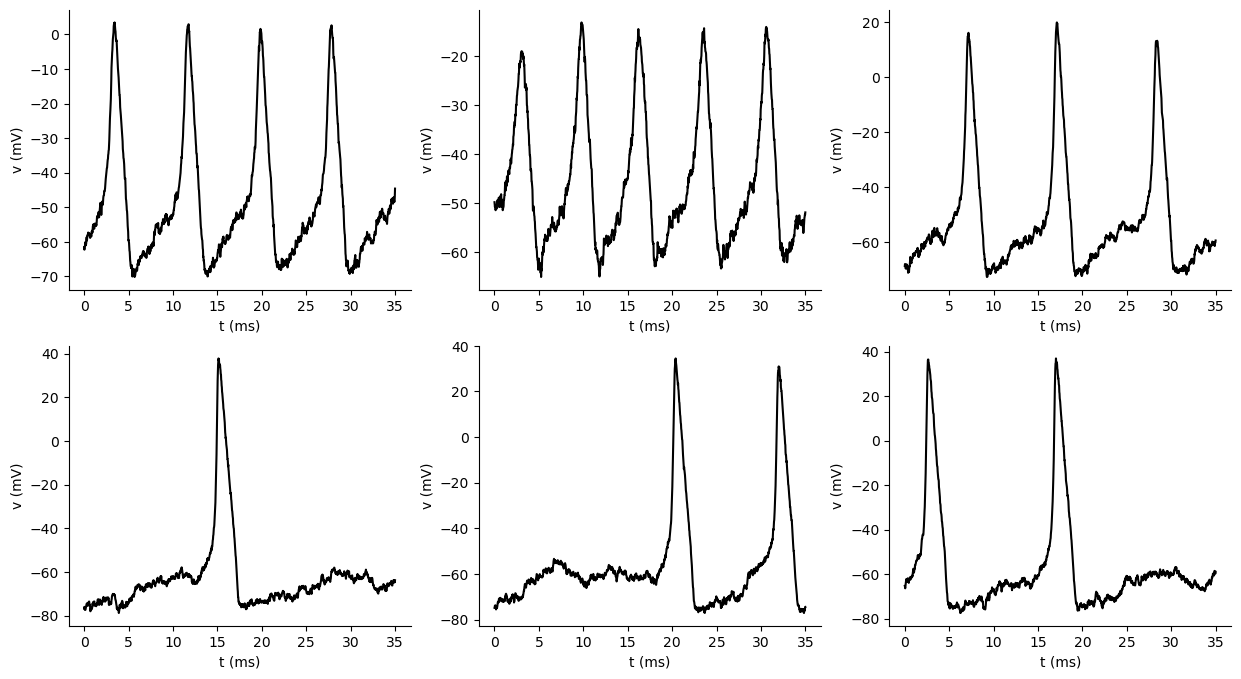

In [36]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(data['t'] - min(data['t']),
             data.iloc[:, i + 1] - 65,
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')

#Alter graphics device attributes
sbn.despine()

#Render visualization to jupyter
plt.show()

### Functionalize Hindmarsh-Rose model

In [37]:
###Fxn block
def hrModl(i_):
    '''
    
    Fxnalized Hindmarsh-Rose modl object
    
    - Modl param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    a, b, c, d = 1, 3, 1, 5
    r, s, x0, w = 0.001, 4, -1.6, 1
    
    #Run controls
    time, dt = 2000, 0.01
    n = time / dt
    t = np.arange(0 + dt, time, dt)
    
    #Anti-bug run controls
    if not len(t) == (n - 1):
        sys.exit(1)
    
    #DAQ tensor instantiation
    sVars = np.zeros((int(n), 3))
    
    #Initialization
    sVars[0] = np.array([0.5, 0.5, 0.5])
    
    #Helper fxns (eqns)
    def dfdt(sVars):
        #Unpack state vars
        x, y, z = sVars
    
        #Compute RHS of ODEs
        dxdt = y - a * x ** 3 + b * x ** 2 - z + (w * gauss(mu = 0, sigma = 1)) + i_
        dydt = c - d * x ** 2 - y
        dzdt = r * (s * (x - x0) - z)
    
        #Fxn I.O
        return(np.array([dxdt, dydt, dzdt]))
    
    #Integrate using forward-Euler formalism
    for i,_ in enumerate(t):
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'t': np.insert(t, 0, 0),
                         'x': sVars[:, 0]}) \
             .query('t >= 1000 & t <= 1750') \
             .reset_index(drop = True) 
    
    #I.O
    return(data)

###Main block
#Compute modl results
hrModl(i_ = 2).head()

,t,x
0,1000.00,-1.369325
1,1000.01,-1.369114
2,1000.02,-1.372216
3,1000.03,-1.381302
4,1000.04,-1.374774


### Subject Hindmarsh-Rose model to random parameter search

$$i \in [1.5, 3]$$

In [38]:
###Main block
#Initialize iterator
i = 0

#Create conditional boundary (i.e., the number of modls to compute)
n = 10 - 1

#DAQ list-column instantiation
modls = []

#Compute modl outputs subject to Monte-Carlo param (i_) selection
while i <= n:
    #Conditionally capture t and x for first iteration
    if i == 0:
        modls.append(hrModl(i_ = uniform(1.5, 3 + 1)))

    #Conditionally capture x for remainder of iterations
    else:
        modls.append(hrModl(i_ = uniform(1.5, 3 + 1))['x'] \
             .rename(f'x{i}'))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,t,x,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1000.00,-0.625505,-1.406760,-0.706623,-1.036151,0.270543,-1.378528,-0.699847,-0.614030,-1.494658,-0.979033
1,1000.01,-0.620250,-1.395562,-0.708857,-1.031606,0.261908,-1.365019,-0.698249,-0.615050,-1.485430,-0.970980
2,1000.02,-0.621145,-1.402694,-0.708143,-1.033252,0.266660,-1.382625,-0.708369,-0.615257,-1.479515,-0.974240
3,1000.03,-0.625611,-1.403542,-0.700213,-1.036128,0.271766,-1.382523,-0.711627,-0.627192,-1.484117,-0.991283
4,1000.04,-0.627292,-1.408587,-0.688396,-1.036596,0.275026,-1.391237,-0.706330,-0.640973,-1.469133,-0.990750


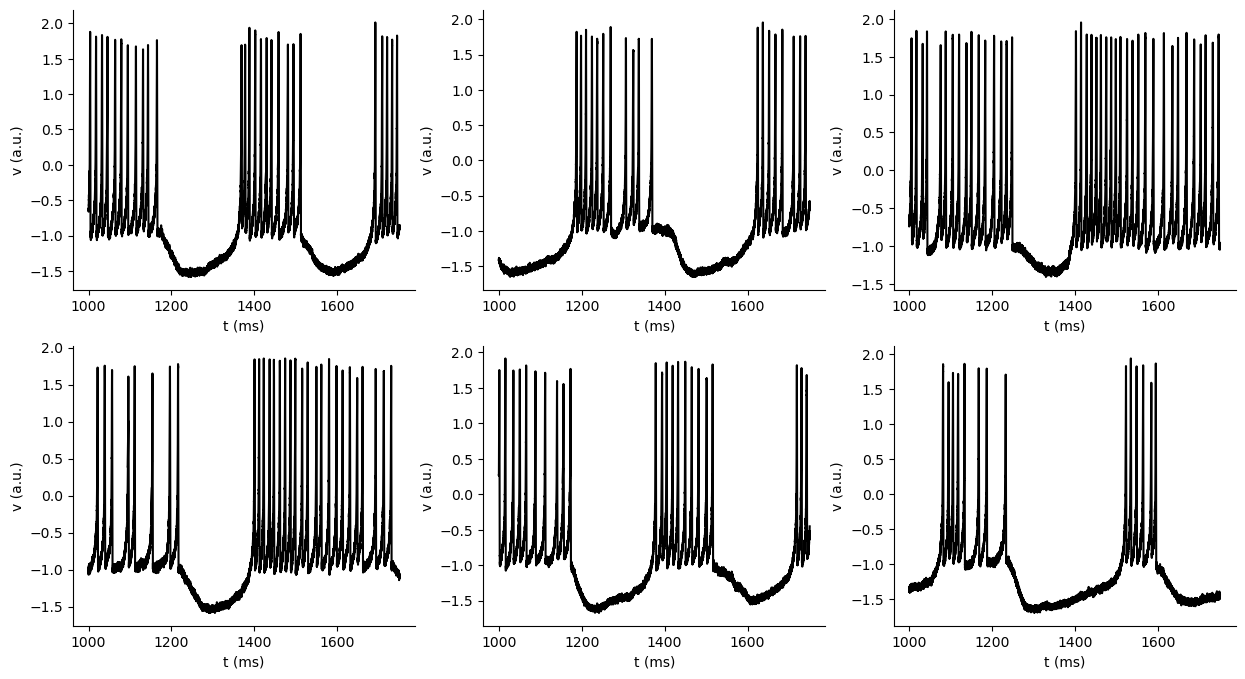

In [39]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(data['t'],
             data.iloc[:, i + 1],
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (a.u.)')

#Alter graphics device attributes
sbn.despine()

#Render visualization to jupyter
plt.show()

# Iterative simulations in series and in parallel

## Iterative simulations in series

### Functionalize Izhikevich model

In [40]:
###Fxn block
def iModl(i_):
    '''
    
    Fxnalized Izhikevich modl object
    
    - Modl param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    a, b, c, d = 0.02, 0.2, -65, 8
    w = 15
    
    #Run controls
    time, dt = 1000, 0.01
    n = time / dt
    t = np.arange(0 + dt, time, dt)
    
    #Anti-bug run controls
    if not len(t) == (n - 1):
        sys.exit(1)
    
    #DAQ tensor instantiation
    sVars = np.zeros((int(n), 2))
    
    #Initialization
    sVars[0] = np.array([-70, 15])
    
    #Helper fxns (eqns)
    def dfdt(sVars):
        #Unpack state vars
        v, u = sVars
    
        #Compute RHS of ODEs
        dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
        dudt = a * (b * v - u)
            
        #Fxn I.O
        return(np.array([dvdt, dudt]))
    
    #Integrate with conditional using forward-Euler formalism
    for i,_ in enumerate(t):
        if sVars[i, 0] >= 30:
            sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])
    
        else:
            sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'t': np.insert(t, 0, 0),
                         'v': sVars[:, 0]}) \
             .query('t >= 900') \
             .reset_index(drop = True) 
    
    #I.O
    return(data)

###Main block
#Compute modl results
iModl(i_ = 10).head()

,t,v
0,900.00,-72.754176
1,900.01,-72.755451
2,900.02,-72.858894
3,900.03,-72.597527
4,900.04,-72.798855


### Subject Izhikevich model to random parameter search

$$i \in [5, 100]$$

#### Benchmark serial execution

In [41]:
###Main block
#Declare number of neurons to simulate
nNeurons = 10 - 1

#DAQ list-column instantiation
modls = []

In [42]:
%%time

#Compute modl outputs subject to Monte-Carlo param (i_) selection
for i in tqdm(range(nNeurons + 1)):
    #Conditionally capture t and v for first iteration
    if i == 0:
        modls.append(iModl(i_ = uniform(5, 100 + 1)))

    #Conditionally capture v for remainder of iterations
    else:
        modls.append(iModl(i_ = uniform(5, 100 + 1))['v'] \
             .rename(f'v{i}'))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.51it/s]

Wall time: 6.61 s


In [43]:
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,t,v,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,900.00,-30.860514,-46.453101,-55.242561,-68.910108,-68.430190,-66.411508,-64.306784,-47.348831,-64.749223,-60.661583
1,900.01,-30.405334,-46.377205,-54.989235,-69.101466,-68.512597,-66.394000,-64.112685,-47.275194,-64.740243,-60.569696
2,900.02,-30.013635,-46.222634,-54.796593,-68.914232,-68.603698,-66.450411,-63.908741,-47.109994,-64.622761,-60.529693
3,900.03,-29.537310,-46.237205,-54.745102,-69.031966,-68.624960,-66.691117,-63.990713,-46.651884,-64.517862,-60.350870
4,900.04,-29.192020,-46.375029,-54.504719,-69.305127,-68.484040,-66.691704,-63.704406,-46.393998,-64.668916,-60.353607


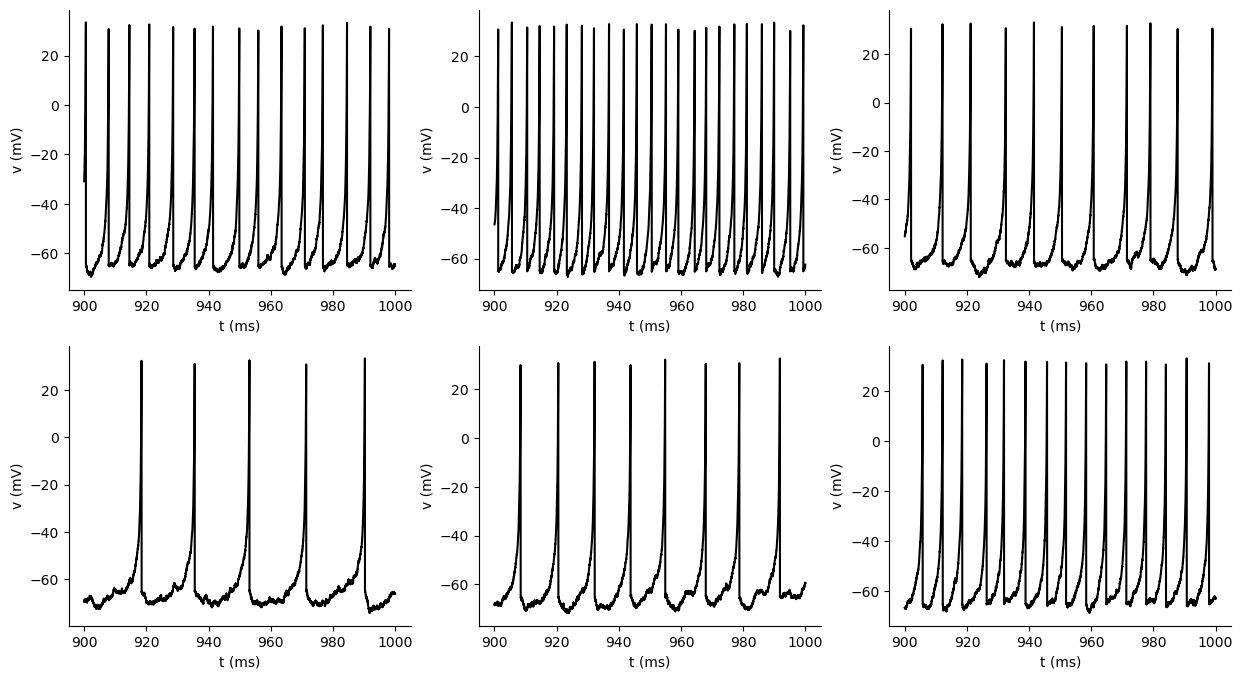

In [44]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(data['t'],
             data.iloc[:, i + 1],
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')

#Alter graphics device attributes
sbn.despine()

#Render visualization to jupyter
plt.show()

## Iterative simulations in parallel

### Functionalize Izhikevich model with ray cluster decorator

In [45]:
###Fxn block
@rClust.remote
def iModl(i_):
    '''
    
    Fxnalized Izhikevich modl object decorated with ray cluster functionality for parallelization
    
    - Model param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    a, b, c, d = 0.02, 0.2, -65, 8
    w = 15
    
    #Run controls
    time, dt = 1000, 0.01
    n = time / dt
    t = np.arange(0 + dt, time, dt)
    
    #Anti-bug run controls
    if not len(t) == (n - 1):
        sys.exit(1)
    
    #DAQ tensor instantiation
    sVars = np.zeros((int(n), 2))
    
    #Initialization
    sVars[0] = np.array([-70, 15])
    
    #Helper fxns (eqns)
    def dfdt(sVars):
        #Unpack state vars
        v, u = sVars
    
        #Compute RHS of ODEs
        dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
        dudt = a * (b * v - u)
            
        #Fxn I.O
        return(np.array([dvdt, dudt]))
    
    #Integrate with conditional using forward-Euler formalism
    for i,_ in enumerate(t):
        if sVars[i, 0] >= 30:
            sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])
    
        else:
            sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'t': np.insert(t, 0, 0),
                         'v': sVars[:, 0]}) \
             .query('t >= 900') \
             .reset_index(drop = True) 
    
    #I.O
    return(data)

### Subject Izhikevich model to random parameter search

$$i \in [5, 100]$$

#### Benchmark parallel execution

In [46]:
###Main block
#Declare number of neurons to simulate
nNeurons = 10 - 1

#Invocation of ray cluster instance
rClust.init()

2023-07-19 15:24:25,744	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.9.13
Ray version:,2.5.1


In [47]:
%%time

##Capture simulative data from parallel subprocesses using list comprehension
#.remote() async assigns nodes/workers in pool task (i.e., computable fxn); creates a future
#.get() sync (i.e., blockingly) retrieves results from nodes/works upon task completion 
temp = rClust.get([iModl \
             .remote(i_ = uniform(5, 100 + 1)) \
             for i in tqdm(range(nNeurons + 1))])

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 879.73it/s]


Wall time: 3.85 s


In [48]:
#Shutdown instantiation of local ray instance
rClust.shutdown()

##Package vectors in nd heterogenous df
#Remove 't' duplicates
data = pd.concat(temp, axis = 1) \
         .T \
         .drop_duplicates(keep = 'first') \
         .T

#Alter df column names
data.columns = ['t', 'v'] + \
               [f'v{i + 1}' for i,_ in enumerate(data.columns.values[2:])]

#I.O
data.head()

,t,v,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,900.00,-66.274603,-68.708892,-60.752930,-65.781999,-58.028644,-67.226544,-45.082146,-55.868267,-64.968383,-64.506681
1,900.01,-66.419335,-68.354809,-60.796294,-65.818037,-57.821680,-67.125874,-45.040949,-55.892121,-64.748357,-64.507025
2,900.02,-66.672954,-68.445488,-60.649757,-65.727585,-57.694493,-67.198658,-44.745706,-55.715022,-64.815404,-64.304236
3,900.03,-66.795803,-68.158090,-60.102883,-65.646810,-57.416068,-66.841525,-44.703867,-55.877677,-64.749401,-64.378992
4,900.04,-66.748611,-68.131054,-59.651832,-65.743995,-57.374383,-66.928736,-44.573881,-55.834968,-64.765731,-64.340184


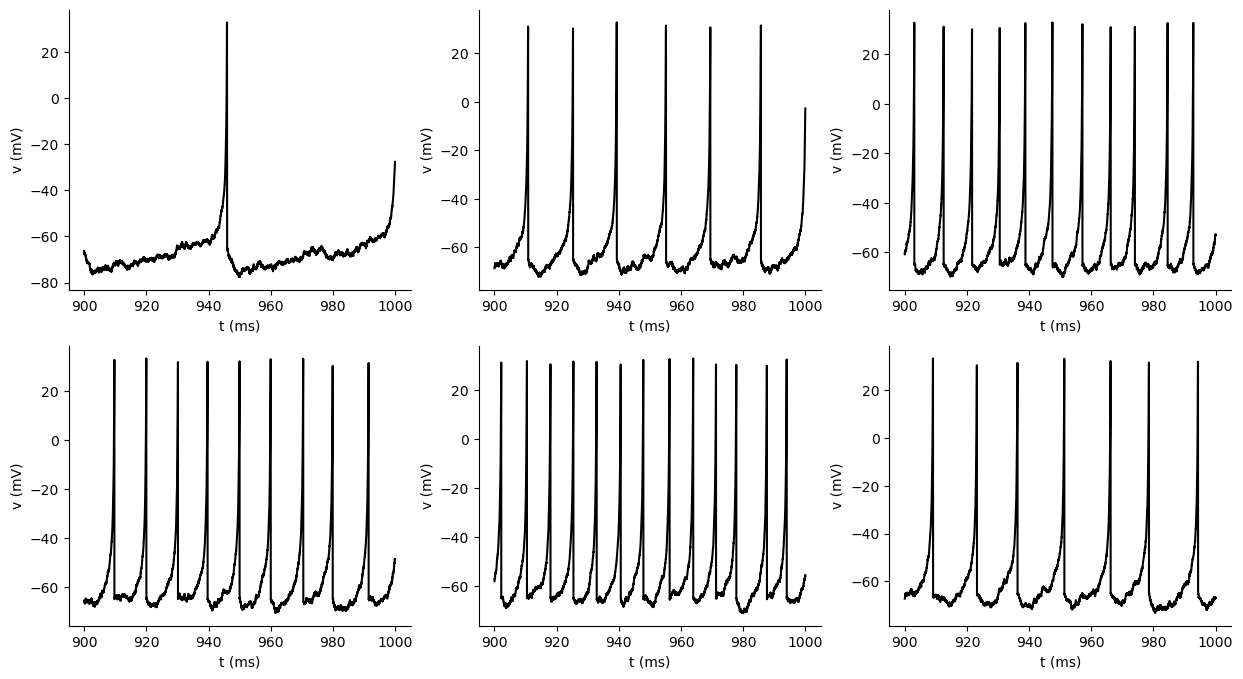

In [49]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(data['t'],
             data.iloc[:, i + 1],
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')

#Alter graphics device attributes
sbn.despine()

#Render visualization to jupyter
plt.show()

## Simulate large number (10,000) of Izhikevich neuron models in spiking and bursting activity regimes

### Recapitulate functionalization of Izhikevich model with conditional control over actvity regime

In [50]:
###Fxn block
@rClust.remote
def iModl(i_, spiker):
    '''
    
    Fxnalized Izhikevich modl object decorated with ray cluster functionality for parallelization;
    Conditional control over activity regime is instantiatied in this fxnalization
    
    - Model param is now fxn arg
        * i_ is parg/kwarg
        * spiker is logical Bool arg
        * all other args locally scoped
    
    '''

    ##Conditional control of activity regime
    #Modl params
    if spiker:
        a, b, c, d = 0.02, 0.2, -65, 8
        w = 15

    else:
        a, b, c, d = 0.02, 0.2, -50, 2
        w = 15
    
    #Run controls
    time, dt = 5000, 0.01
    n = time / dt
    t = np.arange(0 + dt, time, dt)
    
    #Anti-bug run controls
    if not len(t) == (n - 1):
        sys.exit(1)
    
    #DAQ tensor instantiation
    sVars = np.zeros((int(n), 2))
    
    #Initialization
    sVars[0] = np.array([-70, 15])
    
    #Helper fxns (eqns)
    def dfdt(sVars):
        #Unpack state vars
        v, u = sVars
    
        #Compute RHS of ODEs
        dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
        dudt = a * (b * v - u)
            
        #Fxn I.O
        return(np.array([dvdt, dudt]))
    
    #Integrate with conditional using forward-Euler formalism
    for i,_ in enumerate(t):
        if sVars[i, 0] >= 30:
            sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])
    
        else:
            sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'t': np.insert(t, 0, 0),
                         'v': sVars[:, 0]}) \
             .query('t >= 4000') \
             .reset_index(drop = True) 
    
    #I.O
    return(data)

### Subject Izhikevich model to random parameter search

<p style = 'text-align: center;'>For spiking and bursting activity regimes:</p>

$$i \in [5, 25]$$

In [51]:
###Main block
##Declare number of neurons to simulate
#number of batches = total number of neurons / neurons simulated per batch
nNeurons = 5000
nNeuronsPerBatch = 100
nBatches = (nNeurons / nNeuronsPerBatch) - 1

#Invocation of ray cluster instance
rClust.init()

2023-07-19 15:24:44,415	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.9.13
Ray version:,2.5.1


In [52]:
%%time

#Render message
print(f'Batched parallel processing via ray cluster: batches = {int(nBatches) + 1}, neurons/batch = {nNeuronsPerBatch}, total neurons = {nNeurons} \n')

#Compute modl outputs subject to Monte-Carlo param (i_) selection
for i in range(int(nBatches) + 1):
    ###Capture simulative data from parallel subprocesses using list comprehension
    ##.remote() async assigns nodes/workers in pool task (i.e., computable fxn); creates a future
    ##.get() sync (i.e., blockingly) retrieves results from nodes/works upon task completion
    #For Izhikevich model in spiking activity regime
    if i == 0:
        print('~Random parameter search of Izhikevich model in spiking activity regime~ \n')
    
    spikers = rClust.get([iModl \
                    .remote(i_ = uniform(5, 25 + 1), spiker = True) \
                    for i in tqdm(range(nNeuronsPerBatch))])

    ##Package vectors in nd heterogenous df
    #Remove 't' duplicates (spiking activity data)
    dataSpikers = pd.concat(spikers, axis = 1) \
                    .T \
                    .drop_duplicates(keep = 'first') \
                    .T
    
    #Alter df column names (spiking activity data)
    dataSpikers.columns = ['t', 'v'] + \
                          [f'v{i + 1}' for i,_ in enumerate(dataSpikers.columns.values[2:])]

    ###I.O
    ##Spiking activity data
    if i <= (5 - 1):
        print(f'\nModel data rendered as df and dumped to file (batch = {int(i) + 1}): \n')
        display(dataSpikers.head())

        ##Write to file for future recombination
        #file convention: activityRegime_numberOfNeuronsSimulatedPerBatch_batchNumber.csv
        dataSpikers.to_csv(f'./data/batchedData/dataSpikers_100_{i}.csv')

    else:
        print(f'\nModel data dumped to file (batch = {int(i) + 1}) \n')

        ##Write to file for future recombination
        #file convention: activityRegime_numberOfNeuronsSimulatedPerBatch_batchNumber.csv
        dataSpikers.to_csv(f'./data/batchedData/dataSpikers_100_{i}.csv')

Batched parallel processing via ray cluster: batches = 50, neurons/batch = 100, total neurons = 5000 

~Random parameter search of Izhikevich model in spiking activity regime~ 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1044.38it/s]



Model data rendered as df and dumped to file (batch = 1): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-71.790025,-64.210739,-65.495188,-51.126037,-66.348445,-69.847560,-65.826694,-73.565261,-23.507770,...,-68.301152,-69.789538,-65.863526,-59.127957,-64.083380,-61.932184,-72.031129,-27.763280,-71.274074,-56.338361
1,4000.01,-71.564728,-64.028367,-65.317850,-50.792540,-66.518352,-69.582376,-65.763468,-73.469775,-22.818323,...,-68.204309,-69.772992,-65.928224,-59.044148,-64.058675,-61.887312,-72.244743,-27.309039,-71.267354,-56.332132
2,4000.02,-71.552895,-64.254994,-65.502616,-50.670659,-66.299294,-69.665760,-65.745802,-73.292070,-22.324448,...,-68.326811,-69.652732,-66.021845,-58.986706,-64.170411,-61.952142,-72.423645,-26.898603,-71.241493,-56.423504
3,4000.03,-71.403774,-64.243495,-65.301090,-50.561945,-66.477508,-69.772646,-65.745125,-73.112421,-21.429972,...,-68.304127,-69.943274,-65.997554,-59.170261,-64.294307,-62.046115,-72.657321,-26.408842,-71.201273,-56.434753
4,4000.04,-71.370814,-64.064334,-65.581364,-50.533462,-66.373341,-69.541461,-65.608044,-73.099956,-20.923298,...,-68.021735,-70.076305,-65.546059,-58.847268,-64.255198,-62.022487,-72.642969,-25.899701,-71.267294,-56.354019


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1566.72it/s]



Model data rendered as df and dumped to file (batch = 2): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-71.035234,-70.802563,-61.890398,-56.775295,-71.142428,-57.720857,-71.442382,-67.109142,-58.261235,...,-73.008948,-73.297730,-59.150006,-30.408519,-72.522664,-66.710563,-53.437527,-67.416190,-73.184596,-68.441566
1,4000.01,-71.150154,-70.726888,-61.827915,-56.925658,-71.145601,-57.436471,-71.615828,-67.204348,-57.960433,...,-73.433101,-73.199925,-59.359847,-30.115802,-72.577143,-66.679083,-53.350144,-67.613397,-73.097324,-68.426769
2,4000.02,-71.190942,-70.706076,-62.074209,-56.970426,-71.226293,-57.395932,-71.658785,-66.856918,-57.920052,...,-73.662277,-73.297594,-59.575778,-29.655562,-72.710138,-66.651481,-53.538469,-67.509743,-73.307965,-68.299750
3,4000.03,-71.265526,-70.879739,-62.412768,-56.745065,-71.260141,-57.076430,-71.616630,-66.773808,-58.152181,...,-73.727559,-73.335732,-59.481141,-29.253739,-72.871846,-66.672729,-53.497405,-67.516003,-73.457371,-68.186798
4,4000.04,-71.145808,-70.804211,-62.484843,-57.117258,-71.391189,-57.048760,-71.776954,-66.945542,-58.104379,...,-73.712664,-73.206465,-59.553453,-28.765043,-72.906273,-66.632286,-53.421160,-67.586724,-73.689746,-68.247066


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 896.66it/s]



Model data rendered as df and dumped to file (batch = 3): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-73.576667,-68.571792,-65.628903,-60.145964,-62.281071,-74.096740,-60.928042,-69.563150,-69.609721,...,-67.041288,-73.042310,-73.623180,-65.092880,-21.516945,-66.060314,-70.318554,-65.032182,-71.020092,-76.231468
1,4000.01,-73.567089,-68.898760,-65.495318,-60.308952,-62.169617,-74.291664,-60.887374,-69.661756,-69.466617,...,-66.966797,-72.805230,-73.756099,-64.950342,-20.862840,-65.948600,-70.319226,-64.948267,-71.183297,-76.186672
2,4000.02,-73.495265,-68.920699,-65.398901,-60.240539,-61.989615,-74.266969,-60.707346,-69.638527,-69.421284,...,-67.029443,-72.939636,-73.905108,-65.168633,-20.097522,-66.017128,-70.562652,-65.109381,-71.103696,-75.885645
3,4000.03,-73.540252,-68.993094,-65.326199,-60.212254,-62.081007,-74.264407,-60.612323,-69.706546,-68.970581,...,-66.897412,-73.157813,-73.733509,-64.904326,-19.433548,-65.693828,-70.487442,-65.274852,-71.397657,-75.828622
4,4000.04,-73.798030,-68.842704,-65.171512,-60.303948,-62.254404,-74.191517,-60.826443,-69.933615,-69.369213,...,-66.827598,-73.253471,-73.871085,-65.155067,-18.757153,-65.604881,-70.235891,-65.577918,-71.501322,-75.650141


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1548.14it/s]



Model data rendered as df and dumped to file (batch = 4): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-70.121102,-68.760587,-63.671375,-59.397063,-70.203855,-63.511317,-63.928033,-68.085230,-59.388928,...,-72.593655,-61.617111,-24.133254,-72.978469,-72.165319,-69.965672,-67.211337,16.963400,-69.483309,-68.909079
1,4000.01,-70.093472,-68.993587,-63.803368,-59.221537,-70.239450,-63.591557,-64.043623,-67.976588,-59.162463,...,-72.592746,-61.441516,-23.644687,-73.200560,-72.008224,-69.881302,-67.258076,19.267252,-69.528902,-69.311579
2,4000.02,-70.206920,-68.967186,-63.751105,-59.446216,-70.517175,-63.897304,-63.938275,-67.902358,-59.197532,...,-72.600828,-61.503882,-23.066587,-73.412015,-72.141461,-69.991667,-67.121633,21.884687,-69.620952,-69.541211
3,4000.03,-70.238197,-69.052957,-63.705235,-59.405244,-70.537169,-64.143119,-63.969392,-68.078845,-59.257925,...,-72.564787,-61.729733,-22.303158,-73.350418,-71.726932,-69.827125,-67.178719,25.071050,-69.461574,-69.674078
4,4000.04,-70.223453,-69.168856,-63.426016,-59.316091,-70.450674,-64.223084,-63.950446,-68.133418,-59.250350,...,-72.545034,-61.567915,-21.713706,-73.353291,-71.590409,-69.824458,-67.360313,28.476459,-69.435346,-69.300266


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 997.57it/s]



Model data rendered as df and dumped to file (batch = 5): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-71.907501,-58.363424,-34.731795,-67.930348,-73.110596,-67.175092,-69.262409,-63.056696,-55.573862,...,-72.030116,-70.738753,-73.756986,-71.466846,-63.148351,-65.493313,-75.596102,-46.922583,-66.852559,-60.667617
1,4000.01,-71.880642,-58.303285,-34.595050,-68.321815,-72.958967,-67.536633,-69.184653,-63.064823,-55.658871,...,-71.935179,-70.900720,-73.787617,-71.929330,-63.215371,-65.519286,-75.388198,-46.806023,-67.048268,-60.705586
2,4000.02,-71.940198,-58.412067,-34.292799,-68.347779,-73.015009,-67.600883,-69.225560,-63.150160,-55.677182,...,-72.113281,-70.880317,-73.689848,-72.033822,-63.133673,-65.422587,-75.438767,-47.064384,-67.283234,-60.551800
3,4000.03,-71.766591,-58.406468,-34.057166,-68.516620,-72.972671,-67.508928,-69.482792,-63.244226,-55.749532,...,-71.943472,-70.889040,-73.718698,-72.247679,-63.027197,-65.400354,-75.424547,-46.978876,-67.203439,-60.420297
4,4000.04,-71.809774,-58.001489,-33.691894,-68.400069,-72.818614,-67.545078,-69.242145,-63.063892,-55.824446,...,-72.066838,-70.742016,-73.784622,-71.875509,-62.872372,-65.475855,-75.723103,-47.020756,-67.335215,-60.490403


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1072.18it/s]



Model data dumped to file (batch = 6) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 932.60it/s]



Model data dumped to file (batch = 7) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1245.31it/s]



Model data dumped to file (batch = 8) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 741.96it/s]



Model data dumped to file (batch = 9) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1186.45it/s]



Model data dumped to file (batch = 10) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1890.82it/s]



Model data dumped to file (batch = 11) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1882.03it/s]



Model data dumped to file (batch = 12) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1194.00it/s]



Model data dumped to file (batch = 13) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 959.34it/s]



Model data dumped to file (batch = 14) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3602.43it/s]



Model data dumped to file (batch = 15) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 899.12it/s]



Model data dumped to file (batch = 16) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1007.56it/s]



Model data dumped to file (batch = 17) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1592.51it/s]



Model data dumped to file (batch = 18) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1999.14it/s]



Model data dumped to file (batch = 19) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1193.62it/s]



Model data dumped to file (batch = 20) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1637.25it/s]



Model data dumped to file (batch = 21) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1647.73it/s]



Model data dumped to file (batch = 22) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1107.72it/s]



Model data dumped to file (batch = 23) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 932.58it/s]



Model data dumped to file (batch = 24) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1262.78it/s]



Model data dumped to file (batch = 25) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1186.35it/s]



Model data dumped to file (batch = 26) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1188.27it/s]



Model data dumped to file (batch = 27) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1332.67it/s]



Model data dumped to file (batch = 28) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1036.71it/s]



Model data dumped to file (batch = 29) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1848.03it/s]



Model data dumped to file (batch = 30) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2278.35it/s]



Model data dumped to file (batch = 31) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1609.23it/s]



Model data dumped to file (batch = 32) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 858.13it/s]



Model data dumped to file (batch = 33) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1402.05it/s]



Model data dumped to file (batch = 34) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1928.19it/s]



Model data dumped to file (batch = 35) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1420.41it/s]



Model data dumped to file (batch = 36) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 880.24it/s]



Model data dumped to file (batch = 37) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 931.73it/s]



Model data dumped to file (batch = 38) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1351.08it/s]



Model data dumped to file (batch = 39) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 945.72it/s]



Model data dumped to file (batch = 40) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1701.97it/s]



Model data dumped to file (batch = 41) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 837.85it/s]



Model data dumped to file (batch = 42) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1551.49it/s]



Model data dumped to file (batch = 43) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1238.43it/s]



Model data dumped to file (batch = 44) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 825.14it/s]



Model data dumped to file (batch = 45) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1856.68it/s]



Model data dumped to file (batch = 46) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1740.11it/s]



Model data dumped to file (batch = 47) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 753.70it/s]



Model data dumped to file (batch = 48) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1003.18it/s]



Model data dumped to file (batch = 49) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1239.52it/s]



Model data dumped to file (batch = 50) 

Wall time: 2h 11min 26s


In [53]:
%%time

#Render message
print(f'Batched parallel processing via ray cluster: batches = {int(nBatches) + 1}, neurons/batch = {nNeuronsPerBatch}, total neurons = {nNeurons} \n')

#Compute modl outputs subject to Monte-Carlo param (i_) selection
for i in range(int(nBatches) + 1):
    ###Capture simulative data from parallel subprocesses using list comprehension
    ##.remote() async assigns nodes/workers in pool task (i.e., computable fxn); creates a future
    ##.get() sync (i.e., blockingly) retrieves results from nodes/works upon task completion
    #For Izhikevich model in spiking activity regime
    if i == 0:
        print('~Random parameter search of Izhikevich model in bursting activity regime~ \n')
    
    bursters = rClust.get([iModl \
                     .remote(i_ = uniform(5, 25 + 1), spiker = False) \
                     for i in tqdm(range(nNeuronsPerBatch))])

    ##Package vectors in nd heterogenous df
    #Remove 't' duplicates (bursting activity data)
    dataBursters = pd.concat(bursters, axis = 1) \
                     .T \
                     .drop_duplicates(keep = 'first') \
                     .T
    
    #Alter df column names (spiking activity data)
    dataBursters.columns = ['t', 'v'] + \
                           [f'v{i + 1}' for i,_ in enumerate(dataBursters.columns.values[2:])]

    ###I.O
    ##Bursting activity data
    if i <= (5 - 1):
        print(f'\nModel data rendered as df and dumped to file (batch = {int(i) + 1}): \n')
        display(dataBursters.head())

        ##Write to file for future recombination
        #file convention: activityRegime_numberOfNeuronsSimulatedPerBatch_batchNumber.csv
        dataBursters.to_csv(f'./data/batchedData/dataBursters_100_{i}.csv')

    else:
        print(f'\nModel data dumped to file (batch = {int(i) + 1}) \n')

        ##Write to file for future recombination
        #file convention: activityRegime_numberOfNeuronsSimulatedPerBatch_batchNumber.csv
        dataBursters.to_csv(f'./data/batchedData/dataBursters_100_{i}.csv')

Batched parallel processing via ray cluster: batches = 50, neurons/batch = 100, total neurons = 5000 

~Random parameter search of Izhikevich model in bursting activity regime~ 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 670.60it/s]



Model data rendered as df and dumped to file (batch = 1): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-72.060819,-66.179534,-70.233327,-49.595672,-52.404043,-48.579959,-72.710435,-63.407451,-28.405214,...,-75.205165,-69.068178,-69.251159,-45.529775,-51.464340,-40.561091,-69.742862,-71.378821,-54.807162,-46.302464
1,4000.01,-71.994039,-66.314106,-70.105131,-49.672012,-52.505974,-48.508516,-72.601228,-63.229048,-28.006448,...,-75.302516,-69.196393,-69.323957,-45.443211,-51.459105,-40.300107,-69.618177,-71.453924,-54.919962,-46.027381
2,4000.02,-71.984839,-66.244524,-70.122217,-49.757241,-52.366505,-48.560467,-72.307924,-63.224061,-27.638516,...,-75.776154,-69.330225,-69.246568,-45.416947,-51.573352,-40.387977,-69.577655,-71.509664,-54.912163,-45.680909
3,4000.03,-71.794413,-66.563155,-70.278105,-49.921256,-52.447490,-48.257895,-72.452212,-63.204628,-27.442576,...,-75.791641,-69.299808,-68.963041,-45.307697,-51.823043,-40.263644,-69.926304,-71.559480,-54.887649,-45.902449
4,4000.04,-71.816533,-67.008097,-70.440969,-49.967627,-52.474507,-48.224459,-72.579348,-63.276183,-27.039890,...,-75.795765,-69.429664,-68.865887,-45.236728,-51.992782,-40.017860,-70.073752,-71.487835,-55.158295,-45.484362


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1277.04it/s]



Model data rendered as df and dumped to file (batch = 2): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-73.355285,-73.683771,-68.106569,-74.879188,-64.710606,-68.763211,-49.867658,-71.422610,-65.860718,...,-71.166461,-50.633776,-49.766814,-70.498867,-61.294348,-73.017282,-63.403657,-37.396167,-69.813408,-71.782210
1,4000.01,-73.067056,-73.753616,-68.104021,-74.900808,-64.940694,-68.583558,-49.955060,-71.305968,-66.144715,...,-71.295383,-50.822815,-49.885460,-70.472904,-61.240951,-73.085237,-63.538990,-37.073022,-69.690487,-71.677310
2,4000.02,-73.110361,-73.492191,-67.962366,-74.990064,-64.847004,-68.213902,-49.956453,-71.263651,-65.974221,...,-71.260670,-50.780047,-49.887021,-70.469074,-61.166619,-72.899741,-63.653374,-36.880287,-69.803146,-71.556818
3,4000.03,-73.246003,-73.576389,-67.762705,-75.048856,-64.868686,-68.185827,-49.819937,-71.190456,-65.709755,...,-71.503108,-50.797301,-49.898153,-70.292438,-61.449354,-72.876828,-63.617041,-36.725112,-69.844482,-71.662143
4,4000.04,-73.284173,-73.591352,-67.740405,-74.902743,-64.772459,-68.164324,-50.124709,-71.124749,-65.671816,...,-71.553525,-50.728449,-50.064972,-70.090982,-61.676952,-73.024951,-63.692354,-36.724412,-70.031546,-71.794738


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 849.23it/s]



Model data rendered as df and dumped to file (batch = 3): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-23.585223,-65.167215,-71.640753,-45.541458,-47.571708,-70.894449,-73.063354,-55.875488,-50.448055,...,-6.027764,-35.232314,-49.261973,-49.719977,-42.255647,-71.941024,-65.213826,-67.507355,-53.014449,-29.001304
1,4000.01,-23.210162,-65.109719,-71.801778,-45.341906,-47.292720,-70.926157,-73.017719,-55.552320,-50.407411,...,-4.725447,-35.130617,-49.244283,-49.672858,-42.391347,-72.033822,-65.191273,-67.565648,-52.975080,-28.470942
2,4000.02,-22.287614,-64.960779,-71.555034,-45.497036,-47.326714,-70.966597,-73.110106,-55.766370,-50.311154,...,-3.363540,-34.948790,-49.177958,-49.765608,-42.008798,-72.137521,-65.233737,-67.575893,-52.875749,-28.198829
3,4000.03,-21.452524,-64.877826,-71.628152,-45.658736,-47.179837,-70.986806,-73.144637,-55.733984,-50.126814,...,-1.982391,-34.439502,-49.196117,-49.806977,-41.946182,-72.005935,-65.223245,-67.548118,-52.917551,-27.749728
4,4000.04,-20.632488,-64.863091,-71.680583,-45.644159,-46.959077,-70.833315,-73.274973,-55.650738,-50.327271,...,-0.588358,-34.173904,-49.174562,-49.832067,-41.756519,-71.946975,-65.023286,-67.391425,-52.850380,-27.322082


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1421.87it/s]



Model data rendered as df and dumped to file (batch = 4): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-32.327082,-67.615925,-69.949104,-72.368992,-51.367050,-70.126161,-73.432116,-62.223148,-51.251645,...,-48.342728,-62.445811,-59.052417,-36.488911,-59.375641,-72.424829,-72.836578,-68.653923,-68.399372,-48.876794
1,4000.01,-31.828771,-67.604561,-70.056143,-72.210512,-51.233307,-69.854926,-73.508267,-61.902559,-51.183636,...,-48.205234,-62.445695,-59.016785,-36.361877,-59.343708,-72.340970,-73.085798,-68.823407,-68.328640,-49.114112
2,4000.02,-31.508938,-67.613931,-70.137976,-72.379563,-51.312004,-70.239449,-73.487675,-62.132968,-51.127848,...,-48.232108,-62.409235,-58.892572,-36.192964,-59.207319,-72.611758,-72.590359,-68.731697,-68.370586,-49.238762
3,4000.03,-31.149386,-67.616039,-70.278051,-72.339227,-51.447530,-70.580531,-73.449471,-62.119766,-51.106859,...,-47.712802,-62.236559,-59.089143,-35.869037,-59.317975,-73.024625,-72.577769,-68.530175,-68.447960,-49.129611
4,4000.04,-30.807829,-67.611679,-70.331422,-72.359545,-51.427682,-70.544701,-73.409300,-61.886939,-50.980567,...,-47.793493,-62.079624,-59.014662,-35.742168,-59.475005,-73.025624,-72.710238,-68.856642,-68.409391,-49.242321


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2109.96it/s]



Model data rendered as df and dumped to file (batch = 5): 



,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-69.152867,-67.079474,-60.455804,-49.734049,-49.824140,-53.237449,-50.595634,-65.070440,-50.141684,...,-49.474719,-45.092357,8.839472,-68.597429,-71.245351,-41.058048,-74.435239,-64.076619,-47.794551,-64.347726
1,4000.01,-69.140467,-67.226688,-60.575040,-49.549936,-49.822482,-53.086108,-50.532659,-65.120047,-50.265091,...,-49.531398,-45.053046,10.824236,-68.749028,-71.232768,-40.841078,-74.485480,-64.117046,-47.854029,-64.210598
2,4000.02,-69.254651,-67.336585,-60.543209,-49.661229,-50.049692,-53.009226,-50.225459,-65.295273,-50.230177,...,-49.462991,-45.086118,13.095682,-68.610365,-71.301327,-40.638483,-74.459033,-64.184767,-47.933194,-64.279467
3,4000.03,-69.373262,-67.453034,-60.630062,-49.628064,-49.871968,-53.065520,-50.321986,-65.427988,-50.088297,...,-49.251990,-44.956951,15.625831,-68.604980,-71.326999,-40.156341,-74.509332,-64.399655,-47.897379,-64.508589
4,4000.04,-69.455883,-67.475338,-60.595628,-49.907498,-49.710584,-53.149192,-50.386520,-65.569491,-50.074224,...,-49.409414,-44.998397,18.062387,-68.481336,-71.478655,-39.723424,-74.389821,-64.342576,-47.754885,-64.627386


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1266.68it/s]



Model data dumped to file (batch = 6) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 937.31it/s]



Model data dumped to file (batch = 7) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 630.46it/s]



Model data dumped to file (batch = 8) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 562.35it/s]



Model data dumped to file (batch = 9) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 648.33it/s]



Model data dumped to file (batch = 10) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.31it/s]



Model data dumped to file (batch = 11) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1428.50it/s]



Model data dumped to file (batch = 12) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 402.64it/s]



Model data dumped to file (batch = 13) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 838.94it/s]



Model data dumped to file (batch = 14) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 900.06it/s]



Model data dumped to file (batch = 15) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1536.76it/s]



Model data dumped to file (batch = 16) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1121.81it/s]



Model data dumped to file (batch = 17) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1172.50it/s]



Model data dumped to file (batch = 18) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1501.42it/s]



Model data dumped to file (batch = 19) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1542.49it/s]



Model data dumped to file (batch = 20) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1017.77it/s]



Model data dumped to file (batch = 21) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 693.71it/s]



Model data dumped to file (batch = 22) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1555.95it/s]



Model data dumped to file (batch = 23) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1426.04it/s]



Model data dumped to file (batch = 24) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1260.93it/s]



Model data dumped to file (batch = 25) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1507.53it/s]



Model data dumped to file (batch = 26) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1484.87it/s]



Model data dumped to file (batch = 27) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1713.46it/s]



Model data dumped to file (batch = 28) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 899.72it/s]



Model data dumped to file (batch = 29) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1544.48it/s]



Model data dumped to file (batch = 30) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1412.10it/s]



Model data dumped to file (batch = 31) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 996.93it/s]



Model data dumped to file (batch = 32) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1215.16it/s]



Model data dumped to file (batch = 33) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1214.28it/s]



Model data dumped to file (batch = 34) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1359.19it/s]



Model data dumped to file (batch = 35) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1035.21it/s]



Model data dumped to file (batch = 36) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1370.34it/s]



Model data dumped to file (batch = 37) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1058.02it/s]



Model data dumped to file (batch = 38) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 915.58it/s]



Model data dumped to file (batch = 39) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 852.29it/s]



Model data dumped to file (batch = 40) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1185.17it/s]



Model data dumped to file (batch = 41) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1235.13it/s]



Model data dumped to file (batch = 42) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1740.79it/s]



Model data dumped to file (batch = 43) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1372.14it/s]



Model data dumped to file (batch = 44) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1790.42it/s]



Model data dumped to file (batch = 45) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1201.01it/s]



Model data dumped to file (batch = 46) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1617.28it/s]



Model data dumped to file (batch = 47) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1347.68it/s]



Model data dumped to file (batch = 48) 



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1277.03it/s]



Model data dumped to file (batch = 49) 



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 468.62it/s]



Model data dumped to file (batch = 50) 

Wall time: 2h 13min 13s


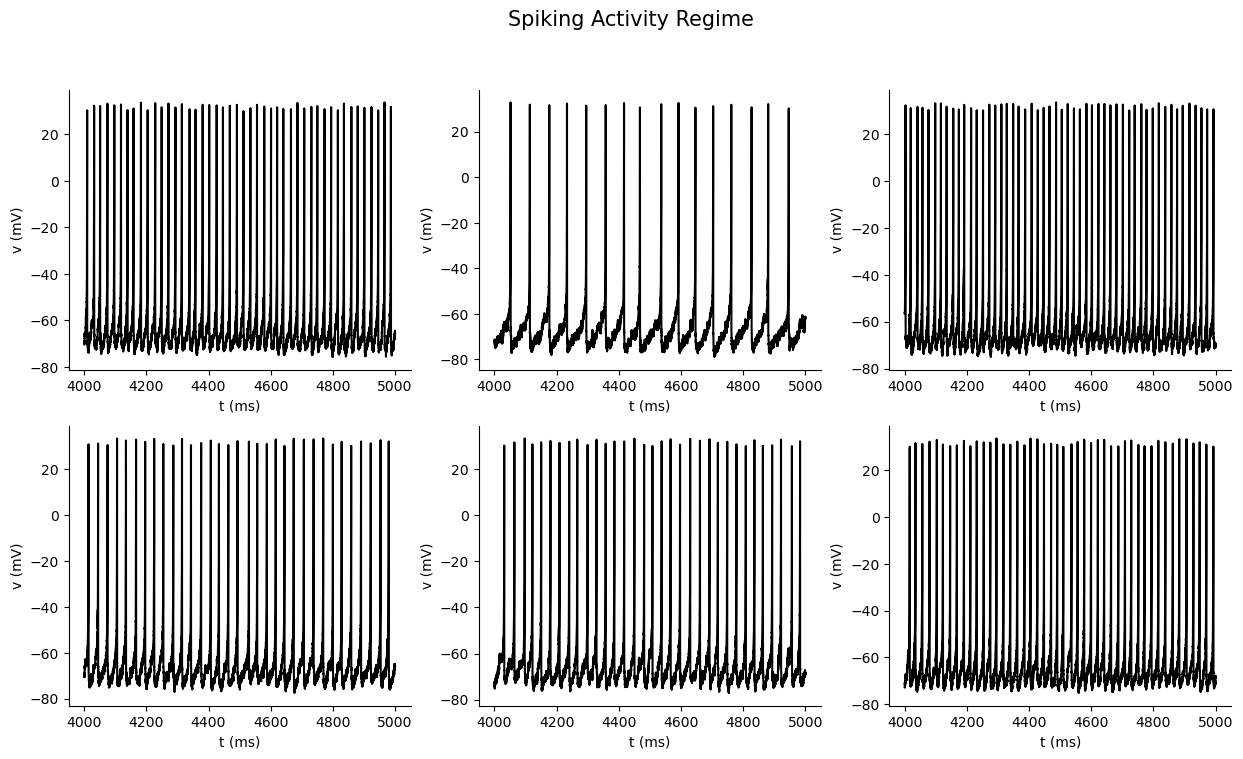

In [54]:
#Shutdown instantiation of local ray instance
rClust.shutdown()

##Visualization (spiking activity data)
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(dataSpikers['t'],
             dataSpikers.iloc[:, i + 1],
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')

#Alter graphics device attributes
sbn.despine()
plt.suptitle('Spiking Activity Regime', 
             fontsize = 15)

#Render visualization to jupyter
plt.show()

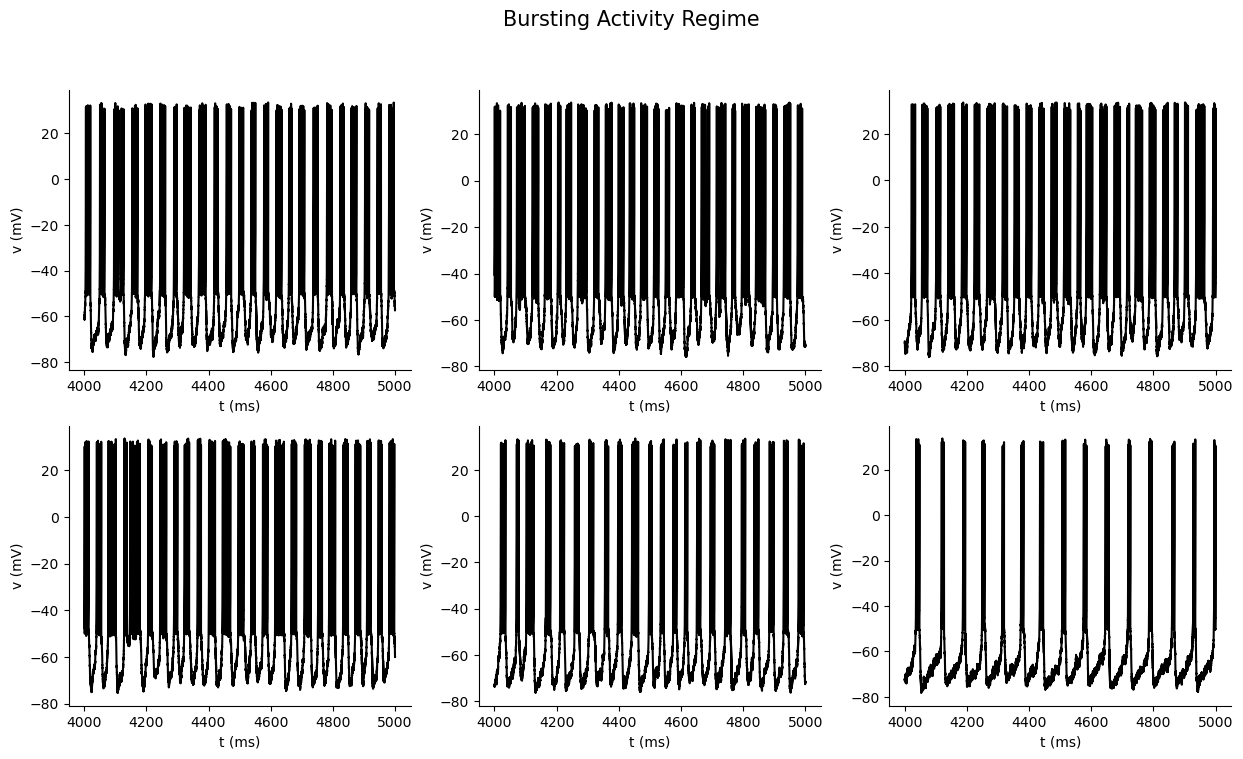

In [55]:
##Visualization (bursting activity data)
#Creation of graphics device
plt.figure(figsize = (15, 8))

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(dataBursters['t'],
             dataBursters.iloc[:, i + 1],
             color = 'black')
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')

#Alter graphics device attributes
sbn.despine()
plt.suptitle('Bursting Activity Regime', 
             fontsize = 15)

#Render visualization to jupyter
plt.show()

# Features of neural activity

## Piecewise algorithmic steps

### 1. Ingest simulated data from which features will be extracted

In [3]:
#Ingest data using pandas
data = pd.read_csv('.\\data\\batchedData\\dataBursters_100_0.csv')

#Drop erroneous columns
del data[data.columns[0]]

#I.O
data.head()

,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4000.00,-72.060819,-66.179534,-70.233327,-49.595672,-52.404043,-48.579959,-72.710435,-63.407451,-28.405214,...,-75.205165,-69.068178,-69.251159,-45.529775,-51.464340,-40.561091,-69.742862,-71.378821,-54.807162,-46.302464
1,4000.01,-71.994039,-66.314106,-70.105131,-49.672012,-52.505974,-48.508516,-72.601228,-63.229048,-28.006448,...,-75.302516,-69.196393,-69.323957,-45.443211,-51.459105,-40.300107,-69.618177,-71.453924,-54.919962,-46.027381
2,4000.02,-71.984839,-66.244524,-70.122217,-49.757241,-52.366505,-48.560467,-72.307924,-63.224061,-27.638516,...,-75.776154,-69.330225,-69.246568,-45.416947,-51.573352,-40.387977,-69.577655,-71.509664,-54.912163,-45.680909
3,4000.03,-71.794413,-66.563155,-70.278105,-49.921256,-52.447490,-48.257895,-72.452212,-63.204628,-27.442576,...,-75.791641,-69.299808,-68.963041,-45.307697,-51.823043,-40.263644,-69.926304,-71.559480,-54.887649,-45.902449
4,4000.04,-71.816533,-67.008097,-70.440969,-49.967627,-52.474507,-48.224459,-72.579348,-63.276183,-27.039890,...,-75.795765,-69.429664,-68.865887,-45.236728,-51.992782,-40.017860,-70.073752,-71.487835,-55.158295,-45.484362


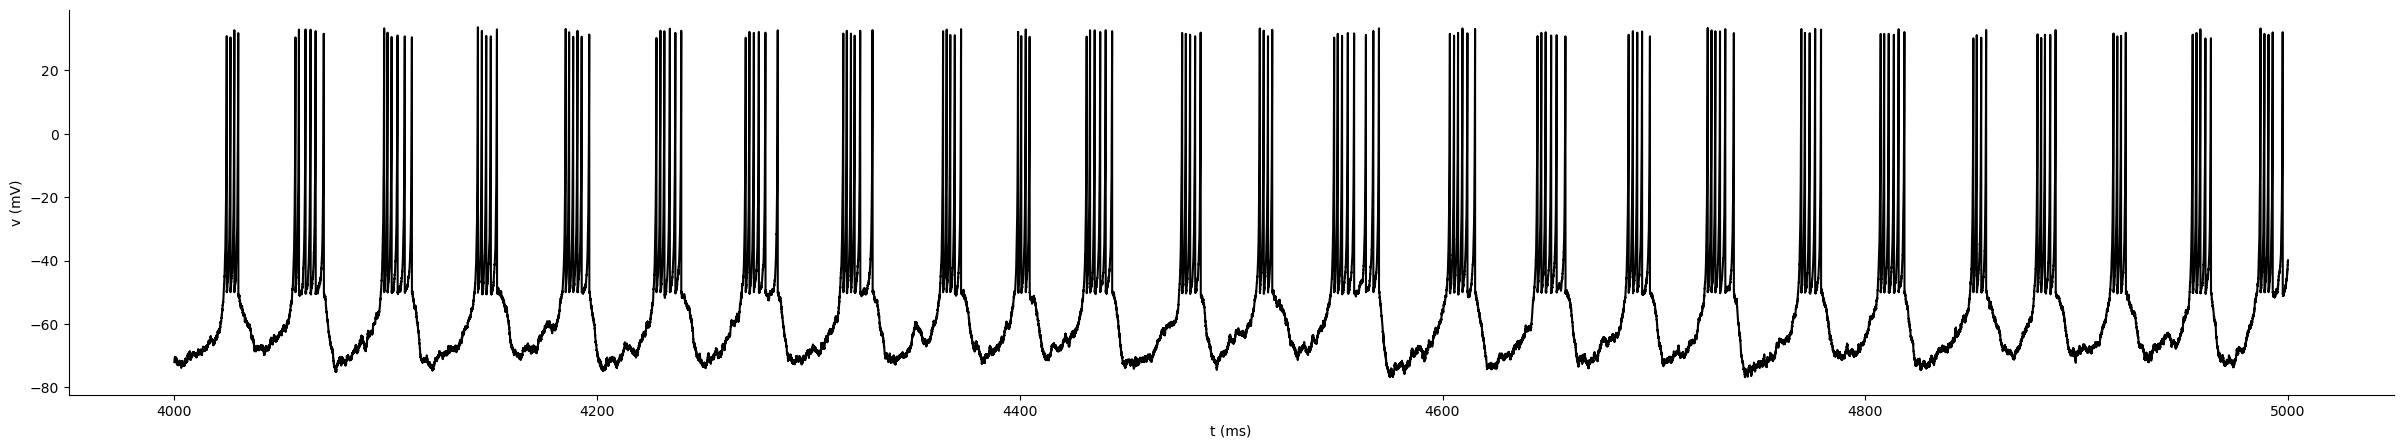

In [4]:
#Visualization
plt.figure(figsize = (30, 5))
plt.plot(data['t'], 
         data['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

### 2. Find local maxima of voltage data, detect spikes

In [5]:
###Spike detection via threshold crossings
##Approximate local maximum (i.e., peaks)
#Uses knowledge of model activity as predicate
peaks,_ = find_peaks(x = data['v'], 
                     threshold = 0, 
                     prominence = 60)

#Spike detection
spikes = data.loc[data \
             .index \
             .isin(peaks),] \
             .reset_index(drop = True)

#I.O
spikes.head()

,t,v,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,4024.79,30.791652,-45.450704,-34.916851,-70.080097,-74.601913,-73.361032,-44.115819,-70.708002,-69.364500,...,-18.794200,-53.323145,-47.500045,-69.211881,-69.403190,-68.344089,-45.020837,-49.277985,-64.620825,-61.836459
1,4026.56,30.384151,-50.778941,-50.558219,-69.269465,-72.364868,-73.256993,-46.559734,-70.305484,-69.175119,...,-7.705468,-60.293319,-50.238756,-69.160754,-68.634520,-66.427017,-47.173733,-18.546972,-64.003760,-51.008052
2,4028.39,32.673258,-57.533609,-54.713482,-66.770424,-73.047530,-71.491671,-48.696933,-70.594945,-70.218108,...,-13.891255,-68.910939,-54.730560,-66.929789,-68.879558,-65.830128,-49.592539,-50.143232,-62.560872,-47.685736
3,4030.24,31.765646,-67.192226,-54.970553,-67.844070,-72.092672,-70.658316,-35.591953,-70.986913,-68.261095,...,-35.612131,-69.803501,-61.096607,-66.625515,-67.343549,-63.596819,-39.472254,-39.333978,-63.906871,-43.984401
4,4057.31,30.394479,-59.687013,-50.083905,-71.996170,-66.504975,-49.413291,-37.213902,-14.013778,-48.675084,...,-66.582587,-31.569845,-61.350992,-53.082159,-70.320933,-32.427925,-63.160639,-69.000247,-73.545262,-67.144064


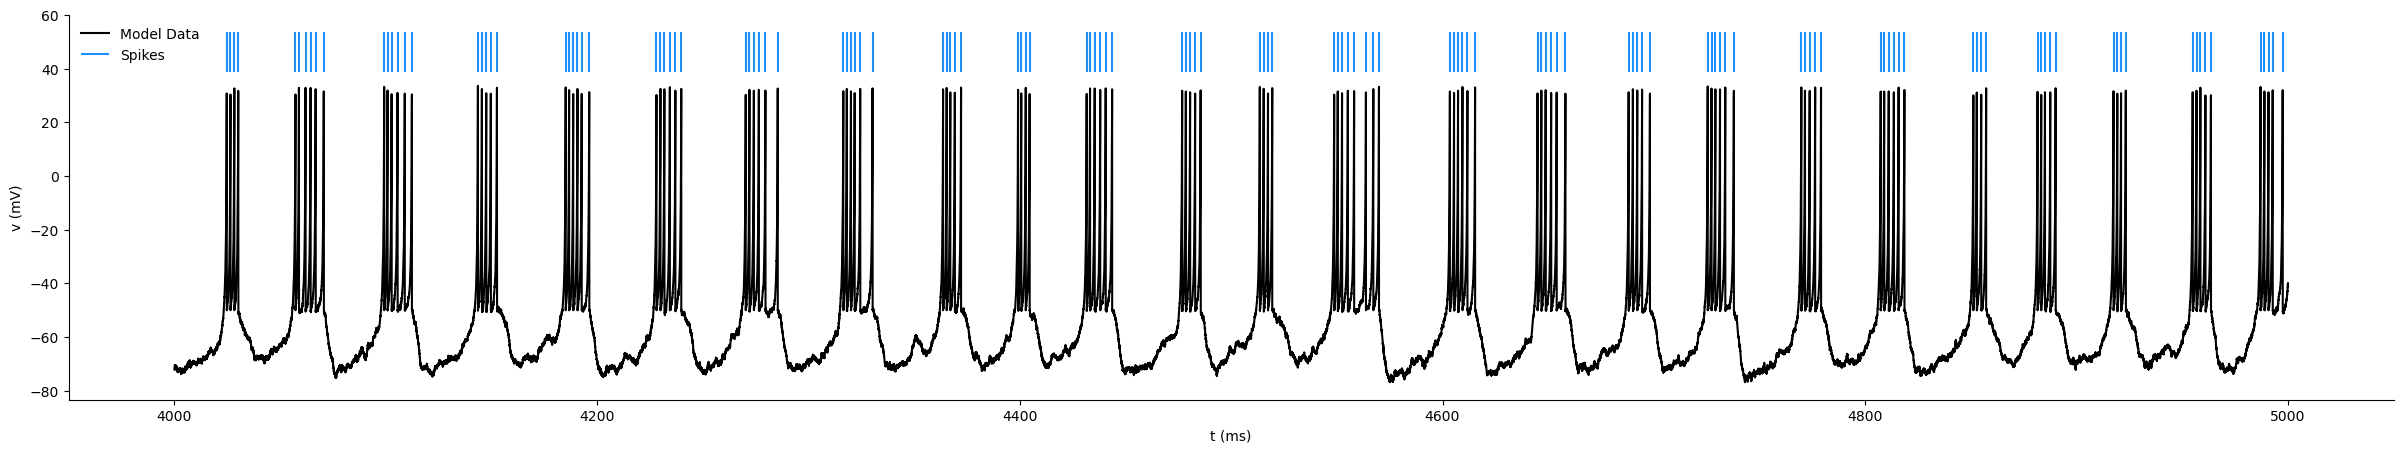

In [6]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (30, 5))

#Plot biologica/model data
plt.plot(data['t'], 
         data['v'],
         color = 'black',
         label = 'Model Data')

#Plot binary spike train
plt.vlines(spikes['t'], 
           data['v'].max() + 5, 
           data['v'].max() + 20, 
           color = 'dodgerblue',
           label = 'Spikes')

#Alter plot attributes
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper left')

#Draw visualization to jupyter
plt.show()

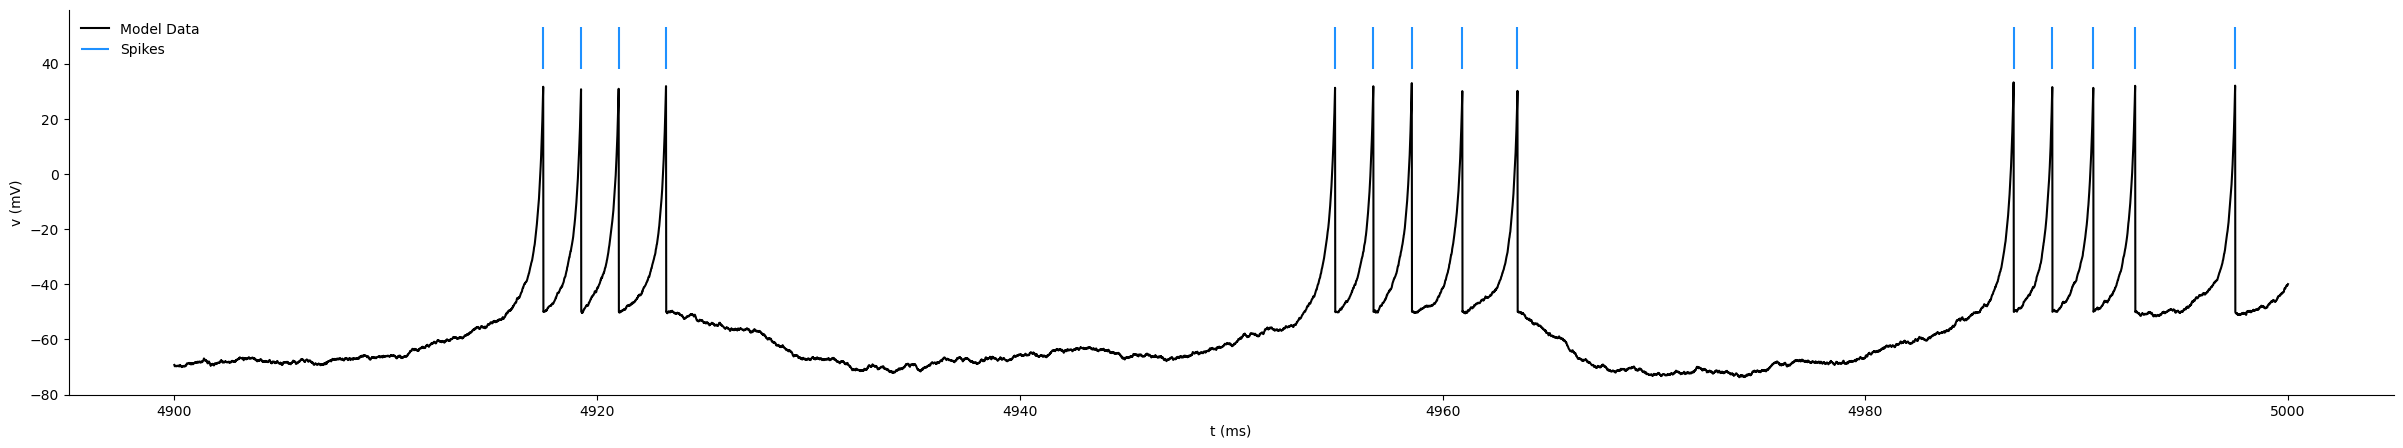

In [7]:
##Wrangle data
#Model data
data_ = data.query('t >= 4900') \
            .reset_index(drop = True)

#Binary spike train data
spikes_ = spikes.query('t >= 4900') \
                .reset_index(drop = True)

##Visualization
#Creation of graphics device
plt.figure(figsize = (30, 5))

#Plot biologica/model data
plt.plot(data_['t'], 
         data_['v'],
         color = 'black',
         label = 'Model Data')

#Plot binary spike train
plt.vlines(spikes_['t'], 
           data_['v'].max() + 5, 
           data_['v'].max() + 20, 
           color = 'dodgerblue',
           label = 'Spikes')

#Alter plot attributes
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')

##Build legend
#Standard legend with mappable 'labels'
plt.legend(frameon = False,
           loc = 'upper left')

#Draw visualization to jupyter
plt.show()

### 3. Compute features: modality of underlying distribution for ISI/IBI

In [8]:
##Simple differentiation of binary spike train across time
#Compute difference between spikes
diff = np.diff(spikes['t'])

#Convert to pandas vector
dataDiff = pd.Series(diff)
dataDiff

0       1.77
1       1.83
2       1.85
3      27.07
4       1.64
       ...  
128    23.47
129     1.83
130     1.94
131     1.98
132     4.73
Length: 133, dtype: float64

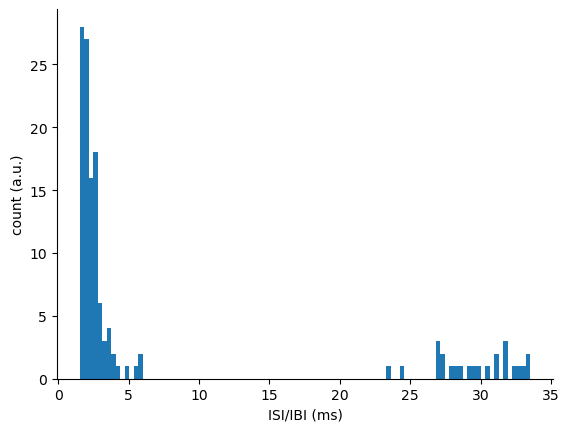

In [9]:
#Visualization
plt.figure()
plt.hist(dataDiff,
         bins = 100)
sbn.despine()
plt.xlabel('ISI/IBI (ms)')
plt.ylabel('count (a.u.)')
plt.show()

In [10]:
##Use dip statistic to check for unimodality
# p >= 0.05 == unimodal (spiker); p < 0.05 == bimodal (burster)
if dip.diptst(dataDiff)[1] >= 0.05:
    print('Number of modes in distribution == 1 (spiker)')

else:
    print('Number of modes in distribution == 2 (burster)')

Number of modes in distribution == 2 (burster)


## Functionalize feature-extraction algorithm

In [11]:
###Fxn block
def featureExtraction(f, flag):
    '''

    Fxnalized feature-extraction algorithm to compute modality of ISI/IBI distribution;
    The Hartigan dip test for unimodality is used to determine unimodality (spiker)/bimodlaity (burster)
    
    - Fxn arg f is file path to batched data csv's
    
    '''

    #Ingest data using pandas
    data = pd.read_csv(f)

    #Drop erroneous/unneeded columns
    del data[data.columns[0]]

    #Instantiate DAQ list
    targetFeature = []

    #Conditionally flag/switch iterable for test and implementation purposes
    if flag == '-test':
        iterable = data.iloc[:, 1:(5 + 1)]

    else:
        iterable = data.iloc[:, 1:]

    #Conditionals for testing
    for _, val in enumerate(iterable):
        ###Spike detection via threshold crossings
        ##Approximate local maximum (i.e., peaks)
        #Uses knowledge of model activity as predicate
        peaks,_ = find_peaks(x = data[val], 
                             threshold = 0, 
                             prominence = 60)
    
        #Spike detection
        spikes = data.loc[data \
                     .index \
                     .isin(peaks),] \
                     .reset_index(drop = True)
    
        ##Simple differentiation of binary spike train across time
        #Compute difference between spikes
        diff = np.diff(spikes['t'])
        
        #Convert to pandas vector
        dataDiff = pd.Series(diff)
    
        ##Use dip statistics to check for unimodality
        # p >= 0.05 == unimodal (spiker); p < 0.05 == bimodal (burster)
        if dip.diptst(dataDiff)[1] >= 0.05:
            temp = ['spiker', 1]
        
        else:
            temp = ['burster', 2]
    
        #Capture target-feature pairs for batched data
        targetFeature.append(temp)

    #I.O
    return(targetFeature)

### Test feature-extraction algorithm on above model data

In [12]:
###Main block
#Relative path of batched data csv
f = ['.\\data\\batchedData\\dataBursters_100_0.csv',
     '.\\data\\batchedData\\dataBursters_100_1.csv']

#Instantiate DAQ list
data = []

#Compute target-feature pairs for all simulated data
for i,_ in enumerate(tqdm(f)):
    #Append target-feature pairs to list
    data.append(featureExtraction(f[i], '-test'))

#Flatten aspects of multi-nested-list dimensionality
temp = [innerNested for outterNested in data \
                    for innerNested in outterNested]

#Package in nd heterogenous df
targetFeature = pd.DataFrame(temp, 
                             columns = ['target', 'feature'])

#I.O
targetFeature.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.77s/it]


,target,feature
0,burster,2
1,burster,2
2,burster,2
3,burster,2
4,burster,2


### Implement feature-extraction algorithm on 10,000 neuron models

In [13]:
#Identify relative path in which to search for regex '*.csv'
rPath = '.\\data\\batchedData\\'

##Use glob method to extract csv's from dir
#Creates list of relative path concatenated with '*.csv' files
f = glob(rPath + "\\*.csv")

#I.O
f[0:5]

['.\\data\\batchedData\\dataBursters_100_0.csv',
 '.\\data\\batchedData\\dataBursters_100_1.csv',
 '.\\data\\batchedData\\dataBursters_100_10.csv',
 '.\\data\\batchedData\\dataBursters_100_11.csv',
 '.\\data\\batchedData\\dataBursters_100_12.csv']

In [14]:
%%time

#Instantiate DAQ list
data = []

#Compute target-feature pairs for all simulated data
for i,_ in enumerate(tqdm(f)):
    #Append target-feature pairs to list
    data.append(featureExtraction(f[i], None))

#Flatten aspects of multi-nested-list dimensionality
temp = [innerNested for outterNested in data \
                    for innerNested in outterNested]

#Package in nd heterogenous df
targetFeature = pd.DataFrame(temp, 
                             columns = ['target', 'feature'])

#I.O
targetFeature.head()

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:32:20<00:00, 54.85s/it]

Wall time: 1h 32min 20s


,target,feature
0,burster,2
1,burster,2
2,burster,2
3,burster,2
4,burster,2


# Mathematics of artifical neural network (ANN) model (using vector operations)

<p style = 'text-align:center;'><img src = './fts/neuralNet.jpg' alt = 'SimplePerceptron' width = '750' height = '500'></p>

<p style = 'text-align: center;'>where:</p> 

$$sig() = \frac{1}{1 + e^{-z}}$$

$$softmax() = \frac{e^{z}}{\sum{e^{z}}}$$